# Personalized Cancer Diagnosis

## [ CONTENTS ] 

1. About the dataset<br>
2. Real-world/Business objectives and constraints<br>
3. Data and Libraries Loading<br>
4. Data Preprocessing <br>
5. Exploratory Data Analysis
6. Naive Bayes on k-Fold cross validation<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Summary<br>

## 1. About the dataset
1. **Title:** Personalized Cancer Diagnosis. Link:https://www.kaggle.com/c/msk-redefining-cancer-treatment/ 
2. **Data:** Memorial Sloan Kettering Cancer Center (MSKCC)
3. **Task:** Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
4. **Relevant Info:** There are nine different classes a genetic mutation can be classified on. This is not a trivial task since interpreting clinical evidence is very challenging even for human specialists. Therefore, modeling the clinical evidence (text) will be critical.
5. **Data includes:**
    * **training_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are <i>ID</i> (the id of the row used to link the mutation to the clinical evidence), <i>Gene</i> (the gene where this genetic mutation is located), <i>Variation</i> (the amino-acid change for this mutations), <i>Class</i> (1-9 the class this genetic mutation has been classified on)
    * **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

## 2. Real-world/Business objective and constraints


**Objective:** Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
<br>
<br>**Constraints:**
<br>
* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

## 3. Data and Libraries Loading

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [3]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## 4. Data Preprocessing

In [5]:
stop_words = set(stopwords.words('english')) 

def txt_preprocessing(total_txt, index, col):
    
    if type(total_txt) is not int:
        string = ''
        total_txt = re.sub('[^a-zA-Z0-9\n]', ' ', total_txt)
        total_txt = re.sub('\s+', ' ', total_txt)
        total_txt = total_txt.lower()
        
        for word in total_txt.split():
            if not word in stop_words:
                string += word + ' '
                
        data_text[col][index] = string

In [6]:
#txt_preprocessing runner 
tic = time.time()

for index, row in data_text.iterrows():
    
    if type(row['TEXT']) is str:
        txt_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

print('Time took for preprocessing the text :', time.time() - tic, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 163.19171690940857 seconds


In [7]:
complete_data = pd.merge(data, data_text, on = 'ID', how = 'left')
complete_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
complete_data[complete_data['TEXT'].isnull()]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
complete_data['TEXT'][complete_data['TEXT'].isnull()] = complete_data['Gene'] +' '+complete_data['Variation']

In [10]:
complete_data[complete_data['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [11]:
y_true = complete_data['Class'].values
complete_data.Gene = complete_data.Gene.str.replace('\s+', '_')
complete_data.Variation = complete_data.Variation.str.replace('\s+', '_')

In [12]:
def data_split(complete_data, ytrue, tsize):
    
    train_x, test_x, train_y, test_y = train_test_split(complete_data, ytrue,
                                                        stratify = ytrue, test_size = tsize,
                                                        random_state = 17)
    if 'Class' in train_x.columns:
        train_x = train_x.drop(['Class'], axis = 1)
        test_x = test_x.drop(['Class'], axis = 1)
    
    return train_x, test_x, train_y, test_y

In [13]:
train_x, test_x, train_y, test_y = data_split(complete_data, y_true, 0.15)
train_datax, crossv_x, train_datay, crossv_y = data_split(train_x, train_y, 0.18)

In [14]:
print('Train set size : {0:10}'.format(len(train_x)))
print('Test set size : {0:10}'.format(len(test_x)))
print('Cross Validation set : {0:2}'.format(len(crossv_x)))

Train set size :       2822
Test set size :        499
Cross Validation set : 508


In [15]:
from sklearn.preprocessing import StandardScaler

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

In [16]:
from sklearn.preprocessing import MaxAbsScaler

def max_abs(data):
    maxabs = MaxAbsScaler()
    result = maxabs.fit_transform(data)
    return result

### 4.1 Categorical Variable Encoding

### [A] One Hot Encode

In [17]:
from sklearn.preprocessing import LabelBinarizer

def onehot_encode(fitter, convert, categories):
    
    encode = LabelBinarizer()
    fit_encoded = encode.fit_transform(fitter)
    encoded = encode.transform(convert)

    fit_encoded = pd.SparseDataFrame(fit_encoded, columns = categories).fillna(0)
    encoded = pd.SparseDataFrame(encoded, columns = categories).fillna(0)
    
    return fit_encoded, encoded

### [B] Response Encode

In [18]:
def feature_dictionary(data, ydata, feature, alpha):
    
    value_count = data[feature].value_counts()
    dict_format = dict()
    
    for i, j in value_count.items():
        vec = []
        for k in range(1, 10):
            class_count = data[(ydata == k) & (data[feature] == i)]
            vec.append((class_count.shape[0] + alpha * 90) / (j + 90 * alpha))
        dict_format[i] = vec
    
    return dict_format

def response_encode(trn_data, ydata, tst_data, feature, alpha):
    
    feature_dict = feature_dictionary(trn_data, ydata, feature, alpha)
    value_count = trn_data[feature].value_counts()
    trn_encoded = []
    
    for index, row in trn_data.iterrows():
        if row[feature] in dict(value_count).keys():
                trn_encoded.append(feature_dict[row[feature]])
        
        else:
                trn_encoded.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
                
    tst_encoded = []
    
    for index, row in tst_data.iterrows():
        if row[feature] in dict(value_count).keys():
                tst_encoded.append(feature_dict[row[feature]])
        
        else:
                tst_encoded.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
            
    return trn_encoded, tst_encoded

### 4.2 TEXT Encoding and Vectorization

In [19]:
import math

def text_response_encode(data, ydata, total_dict, dict_list):
    
    encoded = np.zeros((data.shape[0], 9))
        
    for i in range(0, 9):
        row_index = 0
        for index, row in data.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word, 0)+10) / (total_dict.get(word, 0) + 90)))
            encoded[row_index][i] = math.exp(sum_prob / len(row['TEXT'].split()))
            row_index += 1
    
    return encoded

In [20]:
def unique_words(data):
    
    text_vect = TfidfVectorizer(min_df = 3, stop_words = 'english')
    fit_vect = text_vect.fit(data['TEXT'])
    train_features = text_vect.get_feature_names()
    
    #train_feature_count = np.sum(fit_vect, axis = 0)
    #txt_feature_dict = dict(zip(list(train_features), train_feature_count))
    print('Total Number of Unique Words in Train Data : ', len(train_features))

In [21]:
def text_onehot_encode(train_data, test_data, vectorizer, ngram):
    
    if vectorizer == 'CountVectorizer':
        if ngram == 'Unigram':
            text_vect = CountVectorizer(min_df = 3)
        else:
            text_vect = CountVectorizer(min_df = 3, ngram_range = (1, 2), max_features = 50000)
    else:
        if ngram == 'Unigram':
            text_vect = TfidfVectorizer(min_df = 3, max_features = 1000)
        else:
            text_vect = TfidfVectorizer(min_df = 3, ngram_range = (1, 2), max_features = 1000)
            
    fit_vect = text_vect.fit(train_data['TEXT'])
    train_vect = fit_vect.transform(train_data['TEXT'])
    test_vect = fit_vect.transform(test_data['TEXT'])
    features = text_vect.get_feature_names()
    
    #train_vect = normalize(train_vect, axis=0)
    #test_vect = normalize(test_vect, axis=0)

    where_are_NaNs = pd.isnull(train_vect)
    train_vect[where_are_NaNs] = 0
    where_are_NaNs = pd.isnull(test_vect)
    test_vect[where_are_NaNs] = 0
    
    train_vect = pd.SparseDataFrame(train_vect, columns = features).fillna(0)
    test_vect = pd.SparseDataFrame(test_vect, columns = features).fillna(0)
    
    return train_vect, test_vect

In [22]:
def something(data, labels):
    
    train_x, test_x, train_y, test_y = data_split(data, labels)
    dict_list = []
    for i in range(1, 10):
        cls_text = train_x[train_y == i]
        dict_list.append(extract_dic(cls_text))

    total_dict = extract_dic(train_x['TEXT'])

    confuse_array = []
    for i in train_text_features:
        ratios = []
        max_val = -1
        for j in range(0,9):
            ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
        confuse_array.append(ratios)
    confuse_array = np.array(confuse_array)

## 5. Exploratory Data Analysis 

In [22]:
def distribution_check(data, name):
    classes = np.unique(data)
    freq_counts = []
    print('Class Distribution for {}:'.format(name))
    for c in classes:
        class_count = np.array(data == c).sum()
        freq_counts.append(class_count)
    for i, c in enumerate(list(classes)):
        print('Number of Data Points in Class {} is {} ({}%)'.format(classes[i],
                                                                     freq_counts[i],
                                                                     np.round(freq_counts[i] * 100 / len(data))))
    distribution_plot(classes, freq_counts, name)

In [23]:
def distribution_plot(classes, freq_counts, name):
    sns.set()
    my_color = 'RdPu'
    plt.figure(figsize=(8, 5))
    sns.barplot(x = classes, y = freq_counts, alpha = 1)
    plt.title('Class Distribution plot for {}'.format(name))
    plt.xlabel('Class Labels')
    plt.ylabel('Count')
    plt.show()

Class Distribution for Train Set:
Number of Data Points in Class 1 is 483 (17.0%)
Number of Data Points in Class 2 is 384 (14.0%)
Number of Data Points in Class 3 is 75 (3.0%)
Number of Data Points in Class 4 is 583 (21.0%)
Number of Data Points in Class 5 is 206 (7.0%)
Number of Data Points in Class 6 is 234 (8.0%)
Number of Data Points in Class 7 is 810 (29.0%)
Number of Data Points in Class 8 is 16 (1.0%)
Number of Data Points in Class 9 is 31 (1.0%)


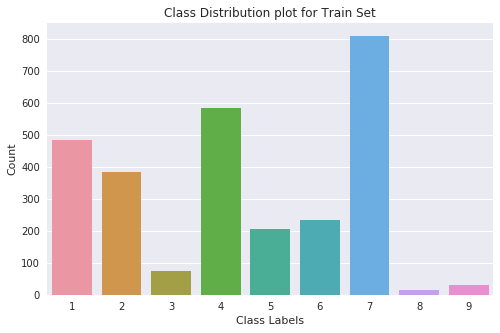

In [22]:
distribution_check(train_y, 'Train Set')

Class Distribution for Test Set:
Number of Data Points in Class 1 is 85 (17.0%)
Number of Data Points in Class 2 is 68 (14.0%)
Number of Data Points in Class 3 is 14 (3.0%)
Number of Data Points in Class 4 is 103 (21.0%)
Number of Data Points in Class 5 is 36 (7.0%)
Number of Data Points in Class 6 is 41 (8.0%)
Number of Data Points in Class 7 is 143 (29.0%)
Number of Data Points in Class 8 is 3 (1.0%)
Number of Data Points in Class 9 is 6 (1.0%)


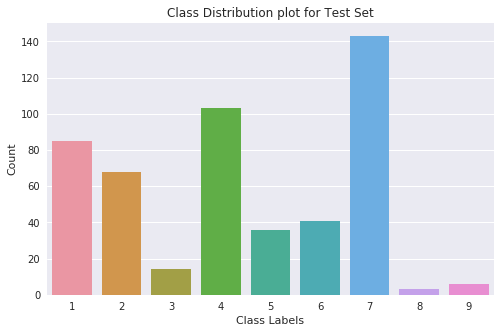

In [23]:
distribution_check(test_y, 'Test Set')

Class Distribution for Cross-Validation Set:
Number of Data Points in Class 1 is 87 (17.0%)
Number of Data Points in Class 2 is 69 (14.0%)
Number of Data Points in Class 3 is 13 (3.0%)
Number of Data Points in Class 4 is 105 (21.0%)
Number of Data Points in Class 5 is 37 (7.0%)
Number of Data Points in Class 6 is 42 (8.0%)
Number of Data Points in Class 7 is 146 (29.0%)
Number of Data Points in Class 8 is 3 (1.0%)
Number of Data Points in Class 9 is 6 (1.0%)


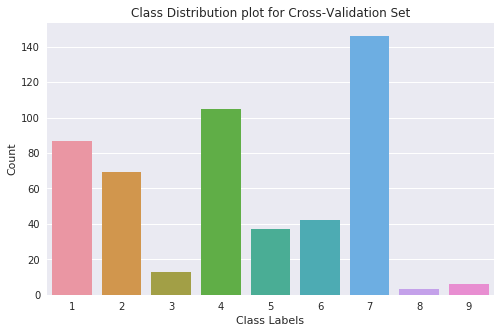

In [24]:
distribution_check(crossv_y, 'Cross-Validation Set')

#### Observation:
* Train, test and cross validation data follows the similar distribution which will help to generalize the model more properly.

### 5.1 Univariate Analysis 

In [24]:
def dist_plot(data, feature):
    
    sns.set()
    plt.figure(figsize = (10, 5))
    sns.distplot(data.values, color = 'b')
    plt.xlabel('Index of Gene')
    plt.ylabel('Num of Occurrence')
    plt.title('Distribution Plot for ' + feature)
    plt.show()
    
    plt.figure(figsize = (10, 5))
    plt.plot(np.cumsum(data.values / sum(data.values)), color = 'b')
    plt.xlabel('Index of Gene')
    plt.ylabel('Cumulative Sum')
    plt.title('Cumulative Distribuition of ' + feature)
    plt.show()  

### [A] Gene

In [25]:
unique_genes = train_x['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
unique_genes.head(10)

Number of Unique Genes : 254


BRCA1     233
TP53      147
EGFR      118
BRCA2     108
PTEN      108
KIT        87
BRAF       77
ERBB2      59
ALK        54
PDGFRA     53
Name: Gene, dtype: int64

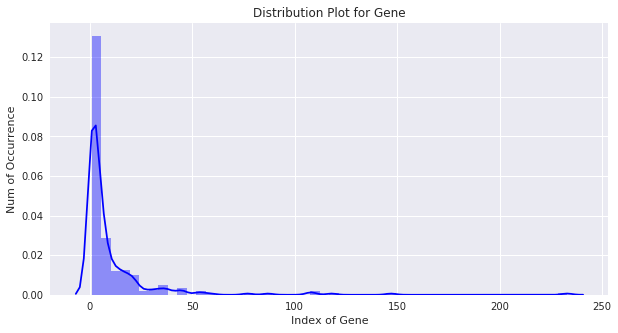

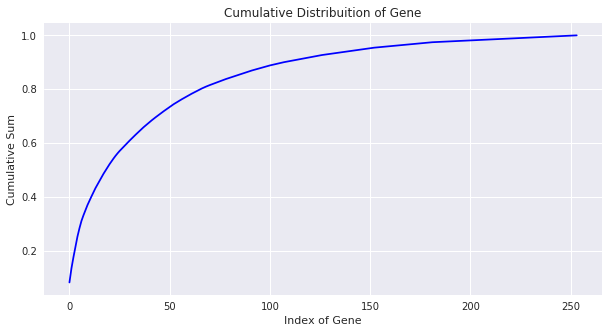

In [27]:
dist_plot(unique_genes, 'Gene')

### [B] Variation

In [28]:
unique_genes = train_x['Variation'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
unique_genes.head(10)

Number of Unique Genes : 2552


Truncating_Mutations    78
Amplification           63
Deletion                60
Fusions                 29
Overexpression           6
G12V                     4
Q61R                     3
T58I                     3
G12S                     2
E17K                     2
Name: Variation, dtype: int64

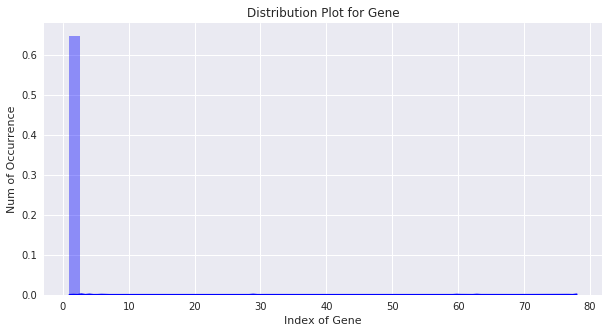

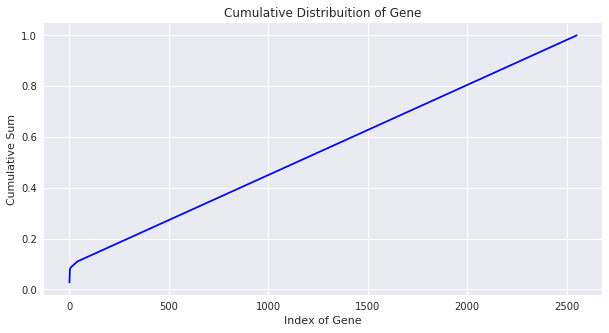

In [29]:
dist_plot(unique_genes, 'Gene')

### [C] Text

In [26]:
def extract_dict(data):
    
    dictionary = defaultdict(int)
    for index, row in data.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    
    return dictionary

In [31]:
unique_words(train_x)

Total Number of Unique Words in Train Data :  60797


### 5.2 Bivariate Analysis 

### [A] Gene and Class 

In [135]:
gene_class = {}
for c in np.unique(train_y):
    temp = train_x[train_y == c]['Gene']
    gene_class[c] = temp

In [161]:
gene_class[1].value_counts().head(10)

TP53       76
BRCA1      54
TSC2       19
BRCA2      16
ERCC2      15
SMAD4      12
VHL        12
SMAD3      11
PTPRT      10
PPP2R1A     9
Name: Gene, dtype: int64

In [166]:
gene_class[2].value_counts().head(10)

KIT       39
EGFR      37
BRAF      27
ABL1      19
ROS1      14
HRAS      13
ERBB2     13
PDGFRB    13
PIK3CA    12
NOTCH1    11
Name: Gene, dtype: int64

In [167]:
gene_class[3].value_counts().head(10)

BRCA1      13
MTOR       11
ALK         7
PDGFRA      6
FLT3        5
TSC1        5
PTEN        4
AKT1        3
ERBB4       3
TMPRSS2     2
Name: Gene, dtype: int64

In [168]:
gene_class[4].value_counts().head(10)

PTEN      98
TP53      59
CDKN2A    40
BRCA1     40
VHL       20
TSC2      18
NF1       14
CBL       13
RUNX1     13
PIK3R1    13
Name: Gene, dtype: int64

In [169]:
gene_class[5].value_counts().head(10)

BRCA1     78
BRCA2     18
FGFR3     10
BRAF       7
PIK3CA     6
IDH1       6
ERBB2      6
PMS2       4
MLH1       4
RET        4
Name: Gene, dtype: int64

In [170]:
gene_class[6].value_counts().head(10)

BRCA2     71
BRCA1     48
MLH1      11
JAK2      10
ERBB2     10
TET2       5
PIM1       4
TP53       4
SMAD2      4
MAP2K1     4
Name: Gene, dtype: int64

In [171]:
gene_class[7].value_counts().head(10)

EGFR      71
KIT       46
BRAF      39
PDGFRA    39
ALK       38
FLT3      34
MTOR      27
KRAS      26
PIK3CA    26
ERBB2     24
Name: Gene, dtype: int64

In [172]:
gene_class[8].value_counts().head(10)

H3F3A     3
AKT1      2
IDH2      2
IDH1      1
DNMT3B    1
RHOA      1
ERBB2     1
RAD51B    1
PTPN11    1
EGFR      1
Name: Gene, dtype: int64

In [173]:
gene_class[9].value_counts().head(10)

SF3B1    10
EZH2      6
IDH1      4
U2AF1     3
AKT2      2
IDH2      2
CTCF      1
TP53      1
CIC       1
MED12     1
Name: Gene, dtype: int64

#### Observation:
* There is no specific gene for specific class of cancer. There as some genes that appear largely in more than one class. 

### [B] Variation and Class 

In [185]:
variation_class = {}
for c in np.unique(train_y):
    temp = train_x[train_y == c]['Variation']
    variation_class[c] = temp

In [176]:
variation_class[1].value_counts().head(10)

Truncating_Mutations    74
Deletion                46
R462C                    1
F134Y                    1
E1071W                   1
V536M                    1
L348S                    1
P70R                     1
F1734S                   1
E70K                     1
Name: Variation, dtype: int64

In [177]:
variation_class[2].value_counts().head(10)

Fusions               27
Amplification         19
Overexpression         2
G13V                   2
T58I                   2
CHTOP-NTRK1_Fusion     1
SSBP2-JAK2_Fusion      1
G469E                  1
G914R                  1
P691S                  1
Name: Variation, dtype: int64

In [178]:
variation_class[3].value_counts().head(10)

R1464*    1
S432L     1
N870S     1
G829R     1
V369G     1
L362R     1
I562M     1
G1286R    1
I834V     1
G591V     1
Name: Variation, dtype: int64

In [179]:
variation_class[4].value_counts().head(10)

Deletion      13
R173C          2
M1_E165DEL     1
R130L          1
A614D          1
I49S           1
G909R          1
G70D           1
D560Y          1
R905Q          1
Name: Variation, dtype: int64

In [180]:
variation_class[5].value_counts().head(10)

K310R     1
N653H     1
D1778Y    1
V191I     1
D1733G    1
C360R     1
N1647K    1
E1282V    1
M1663K    1
E1682K    1
Name: Variation, dtype: int64

In [181]:
variation_class[6].value_counts().head(10)

Amplification           10
Truncating_Mutations     2
Y1045W                   1
R561C                    1
E719G                    1
V2969M                   1
V3079I                   1
D737N                    1
V1804A                   1
S921R                    1
Name: Variation, dtype: int64

In [182]:
variation_class[7].value_counts().head(10)

Amplification        34
Overexpression        4
G12V                  4
Q61R                  3
Q61L                  2
A146T                 2
F28L                  2
ETV6-NTRK3_Fusion     2
Q209L                 2
G12S                  2
Name: Variation, dtype: int64

In [183]:
variation_class[8].value_counts().head(10)

G311D                  1
T798I                  1
S492R                  1
R132Q                  1
E40N                   1
G35V                   1
HMGA2-RAD51B_Fusion    1
G35R                   1
K590R                  1
K179M                  1
Name: Variation, dtype: int64

In [184]:
variation_class[9].value_counts().head(10)

R625D              1
S34Y               1
R132C              1
Q157P              1
G161V              1
Y646S              1
CIC-DUX4_Fusion    1
G44S               1
H662R              1
R625L              1
Name: Variation, dtype: int64

#### Observation:
* In variation also there is no specific variation for each class. Amplification, Deletion etc appear much frequently for more than one class. And it seems there is almost unique variation than single variation repeatedly.

### [C] Text and Class 

In [ ]:
text_class = {}
for c in np.unique(train_y):
    temp = train_x[train_y == c]['TEXT']
    variation_class[c] = temp

## 6. Prediction using a 'Random' Model 

In [23]:
def random_clf(ytrain, ytest):

    ytrain_dummy = np.zeros((1, len(np.unique(ytrain))))
    ytest_dummy = np.zeros((1, len(np.unique(ytest))))
    
    for i in range(len(ytrain)):
        random_probs = np.random.rand(1, len(np.unique(ytrain)))
        ytrain_dummy = np.vstack([ytrain_dummy, random_probs / random_probs.sum()])
    print('Log-Loss on Train-set using Random Model is ', log_loss(ytrain, ytrain_dummy[1:, :]))
    err_metrics(ytrain, np.argmax(ytrain_dummy[1:, :], axis = 1) + 1)
        
    for i in range(len(ytest)):
        random_probs = np.random.rand(1, len(np.unique(ytest)))
        ytest_dummy = np.vstack([ytest_dummy, random_probs / random_probs.sum()])
    print('Log-Loss on Test-set using Random Model is ', log_loss(ytest, ytest_dummy[1:, :]))
    err_metrics(ytest, (np.argmax(ytest_dummy[1:, :], axis = 1)) + 1)

In [24]:
def err_metrics(y, yhat):
    
    confuzn_mtx = confusion_matrix(y, yhat)
    precision_mtx = confuzn_mtx / confuzn_mtx.sum(axis = 0)
    recall_mtx = (confuzn_mtx.T / confuzn_mtx.sum(axis = 1)).T
    labels = np.unique(y)
    
    print('-'*40, 'CONFUSION-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(confuzn_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*40, 'PRECISION-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(precision_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*40, 'RECALL-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(recall_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log-Loss on Train-set using Random Model is  2.471633269051261
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


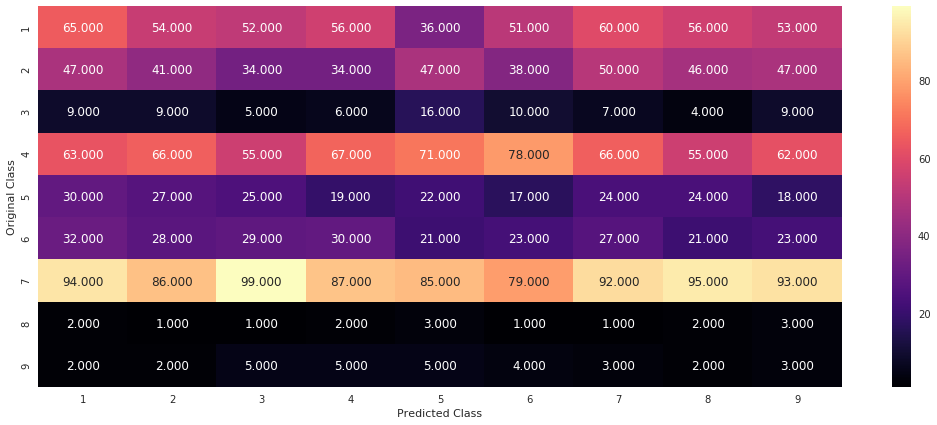

---------------------------------------- PRECISION-MATRIX ----------------------------------------


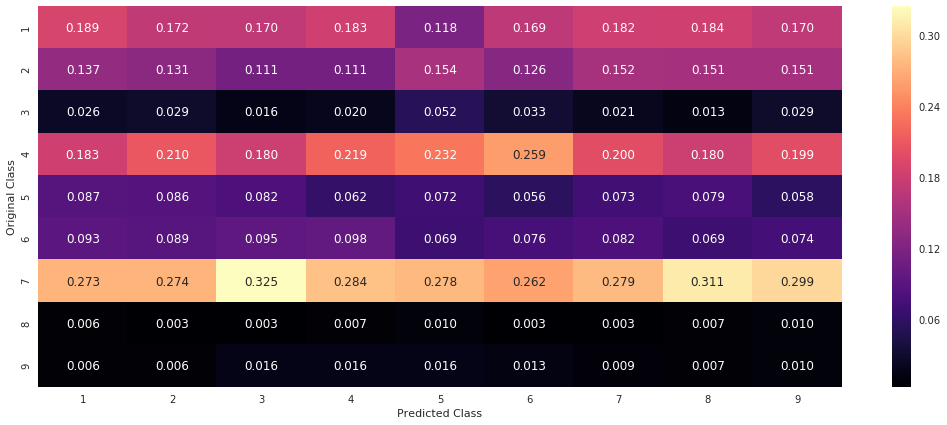

---------------------------------------- RECALL-MATRIX ----------------------------------------


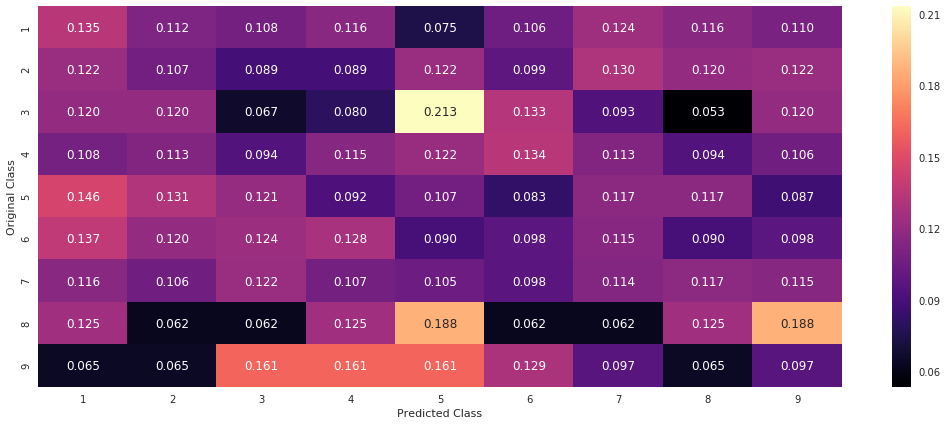

Log-Loss on Test-set using Random Model is  2.5179358638401763
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


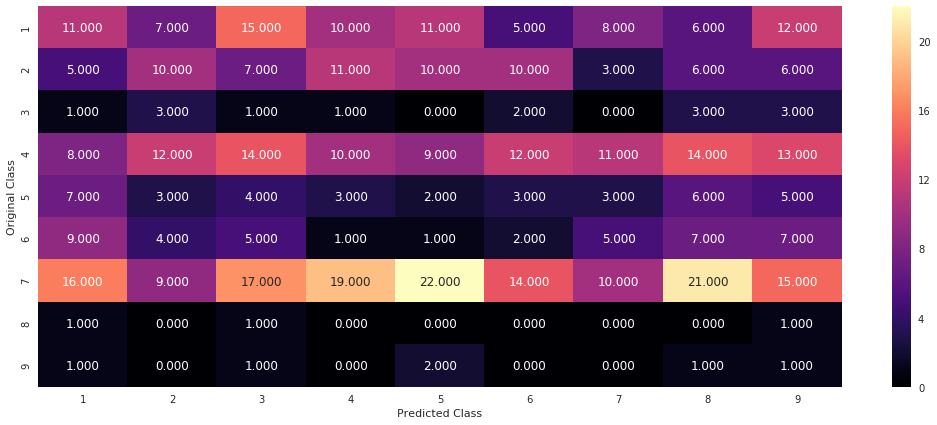

---------------------------------------- PRECISION-MATRIX ----------------------------------------


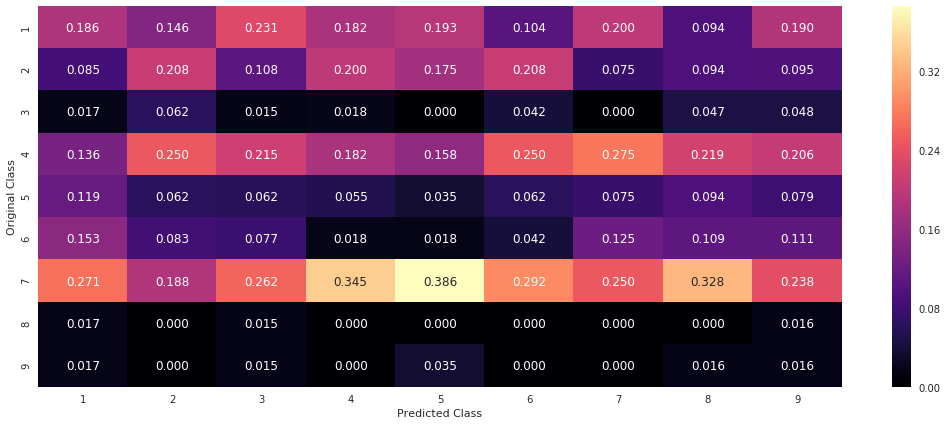

---------------------------------------- RECALL-MATRIX ----------------------------------------


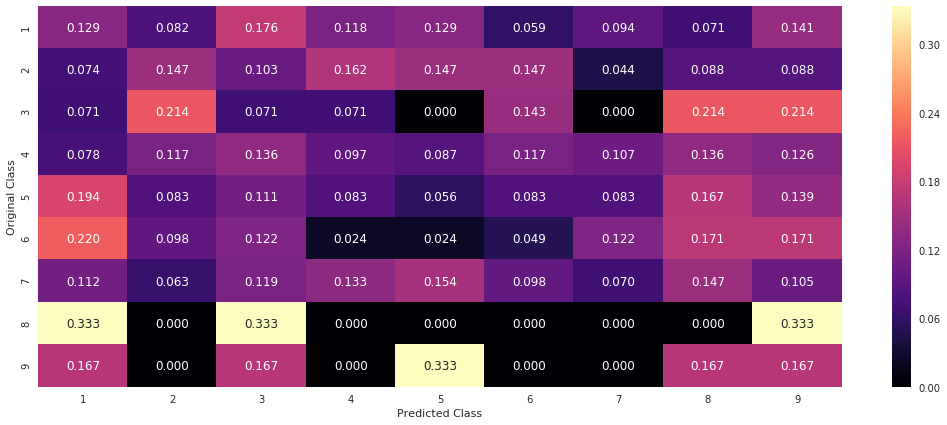

In [34]:
random_clf(train_y, test_y)

#### Observation:
* I have taken random model as the baseline model to register worse case scenario, which will help in understanding how well other models perform compared to the base model.
* And the random model got log loss of 2.52 for test data.

## 7. Feature Importance 

In [25]:
def feature_importance(feature, encode_type, operation, best_alpha = None):
    
    alpha = [10 ** x for x in range(-5, 1)]
    logloss_trn = []
    logloss_cv = []

    if operation == 'Training' and feature != 'TEXT':
        for i in alpha:
                
            if encode_type == 'OneHotEncode':
                trn_x, cv_x = onehot_encode(train_datax[feature], crossv_x[feature], np.unique(train_datax[feature]))
            else:
                trn_x, cv_x = response_encode(train_datax, train_datay, crossv_x, feature, 1)
    
            clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 32)
            clf.fit(trn_x, train_datay)
            
            trn_predproba = clf.predict_proba(trn_x)
            cv_predproba = clf.predict_proba(cv_x)
            
            logloss_trn.append(log_loss(train_datay, trn_predproba))
            logloss_cv.append(log_loss(crossv_y, cv_predproba))
        
        err_curve_sgd(logloss_trn, logloss_cv, alpha)
    
    elif operation == 'Testing' and feature != 'TEXT':
        if encode_type == 'OneHotEncode':
            trn_x, tst_x = onehot_encode(train_x[feature], test_x[feature], np.unique(train_x[feature]))
        else:
            trn_x, tst_x = response_encode(train_x, train_y, test_x, feature, 0.0001)
    
        clf = SGDClassifier(alpha = best_alpha, penalty = 'l2', loss = 'log', random_state = 32)
        clf.fit(trn_x, train_y)
        
        trn_predproba = clf.predict_proba(trn_x)
        tst_predproba = clf.predict_proba(tst_x)

        print('Log-Loss For Train-Set is :', log_loss(train_y, trn_predproba))
        print('Log-Loss For Test-set is  :', log_loss(test_y, tst_predproba))
        
    elif operation == 'Training' and feature == 'TEXT':
        for i in alpha:
                
                if encode_type == 'OneHotEncode':
                    trn_x, cv_x = text_onehot_encode(train_datax, crossv_x, 'TFIDF', 'Unigram')
                else:
                    total_dict = extract_dict(train_datax)
                    dict_list = []
    
                    for i in range(1,10):
                        cls_text = train_datax[train_datay == i]
                        dict_list.append(extract_dict(cls_text))
                
                    trn_x = text_response_encode(train_datax, train_datay,
                                                 total_dict, dict_list)
                    cv_x = text_response_encode(crossv_x, crossv_y,
                                                 total_dict, dict_list)
    
                clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 32)
                clf.fit(trn_x, train_datay)
            
                trn_predproba = clf.predict_proba(trn_x)
                cv_predproba = clf.predict_proba(cv_x)
                
                trn_predproba = np.nan_to_num(trn_predproba)
                cv_predproba = np.nan_to_num(cv_predproba)
            
                logloss_trn.append(log_loss(train_datay, trn_predproba))
                logloss_cv.append(log_loss(crossv_y, cv_predproba))
        
        err_curve_sgd(logloss_trn, logloss_cv, alpha)
        
    else:
        if encode_type == 'OneHotEncode':
            trn_x, tst_x = text_onehot_encode(train_x, test_x, 'TFIDF', 'Unigram')
        else:
            total_dict = extract_dict(train_x)
            dict_list = []
        
            for i in range(1,10):
                cls_text = train_x[train_y == i]
                dict_list.append(extract_dict(cls_text))
        
            trn_x = text_response_encode(train_x, train_y,
                                         total_dict, dict_list)
            tst_x = text_response_encode(test_x, test_y,
                                         total_dict, dict_list)
    
        clf = SGDClassifier(alpha = best_alpha, penalty = 'l2', loss = 'log', random_state = 32)
        clf.fit(trn_x, train_y)
        
        trn_predproba = clf.predict_proba(trn_x)
        tst_predproba = clf.predict_proba(tst_x)
        
        trn_predproba = np.nan_to_num(trn_predproba)
        tst_predproba = np.nan_to_num(tst_predproba)

        print('Log-Loss For Train-Set is :', log_loss(train_y, trn_predproba))
        print('Log-Loss For Test-set is  :', log_loss(test_y, tst_predproba))

In [26]:
def err_curve_sgd(train_loss, cv_loss, alpha):
    
    plt.figure(1)
    plt.figure(figsize = (8, 5))
    plt.plot(alpha, cv_loss, label = 'cv_error', color = 'r')
    plt.plot(alpha, train_loss, label = 'train_error', color = 'b')
    plt.xscale('log')
    plt.xlabel('Alpha-Values')
    plt.ylabel('Error Values')
    plt.legend()
    plt.title('CV & TRAIN-ERR')
    plt.show()

### [A] Gene as OneHotEncoded

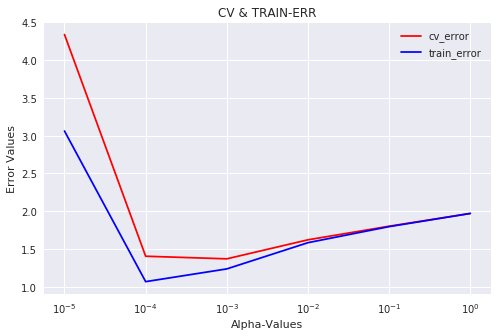

In [46]:
feature_importance('Gene', 'OneHotEncode', 'Training')

In [39]:
feature_importance('Gene', 'OneHotEncode', 'Testing', 0.001)

Log-Loss For Train-Set is : 1.239790967032029
Log-Loss For Test-set is  : 1.3048179507025817


#### Observation:
* As only the Gene feature(OneHotEncoded) resulted in log loss much more less than the random model, so it seems important.

### [B] Gene as ResponseEncoded

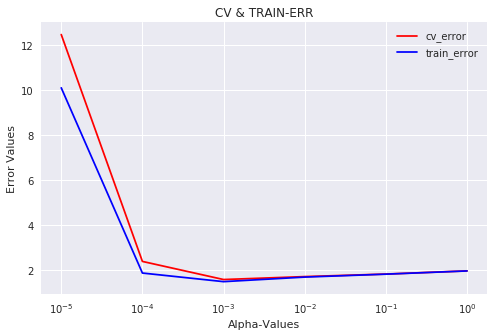

In [49]:
feature_importance('Gene', 'ResponseEncode', 'Training')

In [40]:
feature_importance('Gene', 'ResponseEncode', 'Testing', 0.001)

Log-Loss For Train-Set is : 1.039163301853257
Log-Loss For Test-set is  : 1.2071400146531357


#### Observation:
* Only the Gene feature(ResponseEncoded) resulted in log loss much more less than the random model, so it seems important.

### [C] Variation as OneHotEncoded

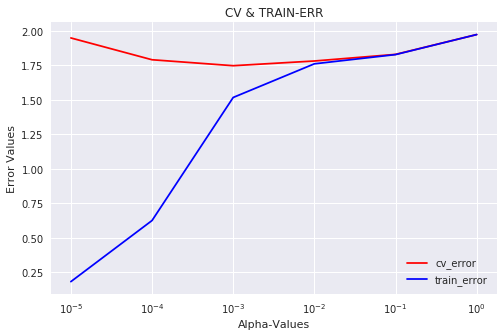

In [51]:
feature_importance('Variation', 'OneHotEncode', 'Training')

In [41]:
feature_importance('Variation', 'OneHotEncode', 'Testing', 0.01)

Log-Loss For Train-Set is : 1.7629970664786916
Log-Loss For Test-set is  : 1.7922614138752535


#### Observation:
* Only the Variation feature(OneHotEncode) resulted in less log loss than the random model, so it seems important.

### [D] Variance as ResponseEncoded

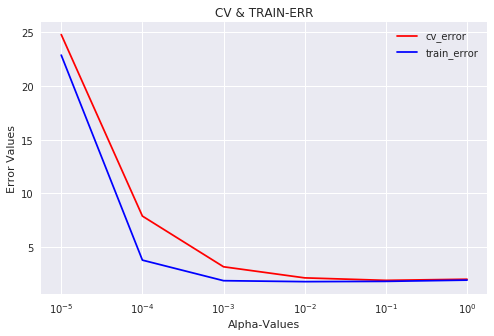

In [53]:
feature_importance('Variation', 'ResponseEncode', 'Training')

In [42]:
feature_importance('Variation', 'ResponseEncode', 'Testing', 0.1)

Log-Loss For Train-Set is : 1.2138395219876423
Log-Loss For Test-set is  : 1.8032819935800937


#### Observation:
* Only the Variation feature(ResponseEncoded) resulted in less log loss than the random model, so it seems important.

### [E] TEXT as OneHotEncoded

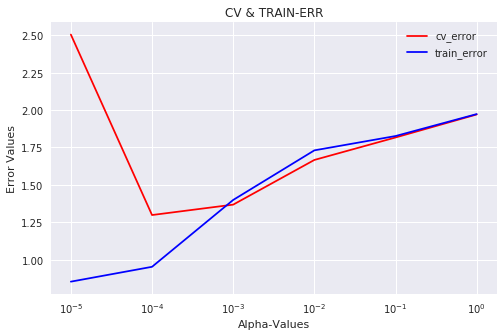

In [57]:
feature_importance('TEXT', 'OneHotEncode', 'Training')

In [43]:
feature_importance('TEXT', 'OneHotEncode', 'Testing', 0.0001)

Log-Loss For Train-Set is : 0.9601913485275808
Log-Loss For Test-set is  : 1.1354209617000348


#### Observation:
* Only TEXT feature also resulted in less log loss than the random model, so it is also important.

## 8. Machine Learning Models

### [A] Stacking All Features

In [27]:
def feature_stack(trn_data, trn_ydata, tst_data, tst_ydata, encode_type, vectorizer = None, ngram = None):
    
    if encode_type == 'OneHotEncode':
        
        gene_cat = np.unique(trn_data['Gene'])
        var_cat = np.unique(trn_data['Variation'])
        trn_gene, tst_gene = onehot_encode(trn_data['Gene'], tst_data['Gene'], gene_cat)
        trn_var, tst_var = onehot_encode(trn_data['Variation'], tst_data['Variation'], var_cat)
        trn_txt, tst_txt = text_onehot_encode(trn_data, tst_data, vectorizer, ngram)
        
        total_trn_data = pd.concat([trn_gene, trn_var], axis = 1)
        total_trn_data = pd.concat([total_trn_data, trn_txt], axis = 1)
        total_tst_data = pd.concat([tst_gene, tst_var], axis = 1)
        total_tst_data = pd.concat([total_tst_data, tst_txt], axis = 1)
        
        
    else:
        total_dict = extract_dict(trn_data)
        dict_list = []
        
        for i in range(1,10):
            cls_text = trn_data[trn_ydata == i]
            dict_list.append(extract_dict(cls_text))
        
        trn_gene, tst_gene = response_encode(trn_data, trn_ydata, tst_data, 'Gene', 1)
        trn_var, tst_var = response_encode(trn_data, trn_ydata, tst_data, 'Variation', 1)
        trn_txt = text_response_encode(trn_data, trn_ydata, total_dict, dict_list)
        tst_txt = text_response_encode(tst_data, tst_ydata, total_dict, dict_list)
        
        total_trn_data = np.hstack([trn_gene, trn_var, trn_txt])
        total_tst_data = np.hstack([tst_gene, tst_var, tst_txt])
        
    return total_trn_data, total_tst_data

### 8.1 Naive Bayes

In [80]:
def naive_bayes_model(operation, encode_type, best_alpha = None, vectorizer = None, ngram = None):
    
    alpha = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for a in alpha:
            clf = MultinomialNB(alpha = a, fit_prior = False)
            clf.fit(trn_data, train_datay)
            pred_proba_trn = clf.predict_proba(trn_data)
            pred_proba_cv = clf.predict_proba(cv_data)
            train_err.append(log_loss(train_datay, pred_proba_trn))
            cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare(train_err, cv_err, alpha, 'Alpha')
    else:
        clf = MultinomialNB(best_alpha, fit_prior = False)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type, vectorizer, ngram)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        pred_proba_trn = clf.predict_proba(trn_data)
        pred_proba_tst = clf.predict_proba(tst_data)
        trn_err = clf.score(trn_data, train_y)
        tst_err = clf.score(tst_data, test_y)
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [93]:
def nb_query(best_alpha, query_indx, vectorizer = None, ngram = None):

    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'OneHotEncode', vectorizer, ngram)
    clf = MultinomialNB(best_alpha, fit_prior = False)
    clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    sorted_indices = (-clf.feature_log_prob_[pred_cls - 1]).argsort()[:, :num_feature]
    imp_features = np.take(tst_data.columns, sorted_indices)
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in np.unique(train_x['Gene']):
                print('Feature from Gene :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            elif tst_data.columns[i] in np.unique(train_x['Variation']):
                print('Feature from Variation :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            else:
                print('Feature from TEXT',tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
    present_word = []
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in test_x['TEXT'].iloc[query_indx]:
                present_word.append(tst_data.columns[i])
    print('These Texts are present in the given query : ')
    print(present_word)

In [28]:
def err_compare(train_err, cv_err, hyp_param, param_name):
    sns.set()
    plt.figure(1)
    plt.figure(figsize=(8, 5))
    plt.plot(hyp_param, cv_err, label = 'cv_error', color = 'r')
    plt.plot(hyp_param, train_err, label = 'train_error', color = 'b')
    if param_name != 'K':
        plt.xscale('log')
    plt.xlabel(param_name + ' Values')
    plt.ylabel('Log-Loss Values')
    plt.legend()
    plt.title('CV & TRAIN-ERR')

### [A] Log Loss Curve

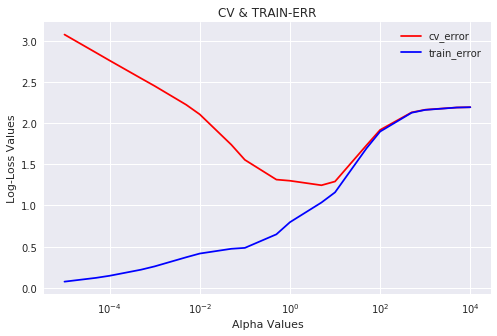

In [89]:
naive_bayes_model('Training', 'OneHotEncode', vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* From the log loss curve best fit alpha for this model seems near to 10. And I'm taking alpha = 7 as best fit hyper-parameter.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 1.0855818529136978
Log-Loss for Test-set is : 1.2507719359701714
Train Accuracy is : 0.669029057406095
Test Accuracy is : 0.5871743486973948
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


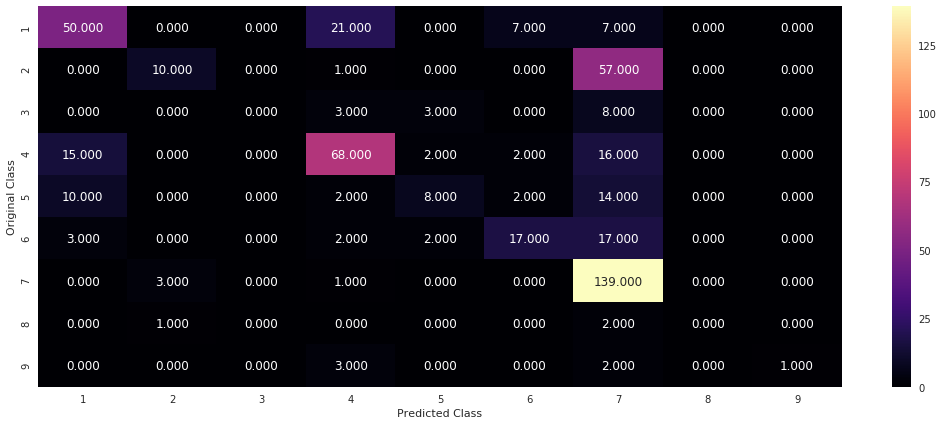

---------------------------------------- PRECISION-MATRIX ----------------------------------------


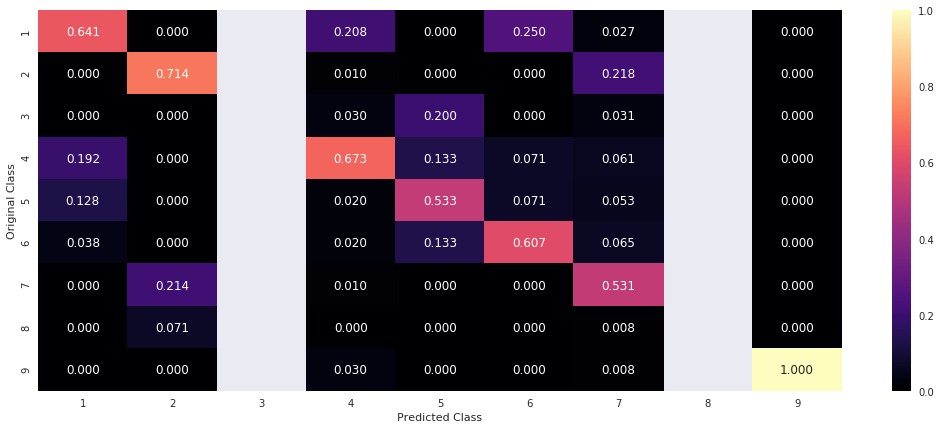

---------------------------------------- RECALL-MATRIX ----------------------------------------


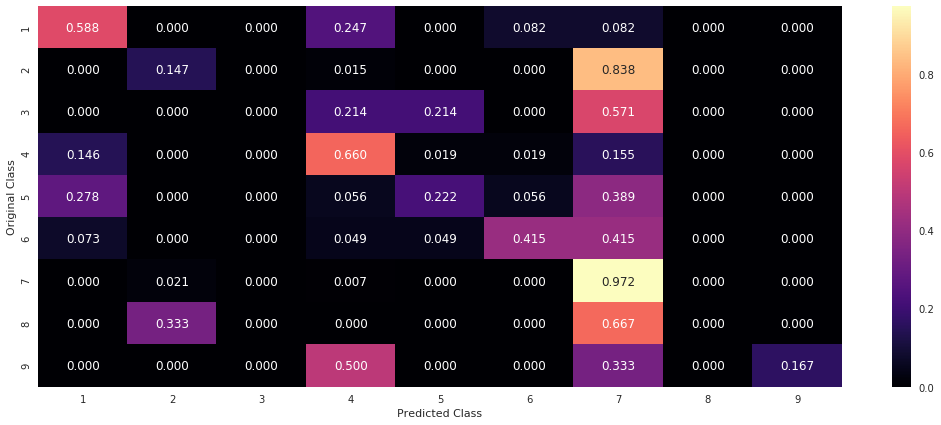

In [92]:
naive_bayes_model('Testing', 'OneHotEncode', 7, vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* For TFIDF(Unigram) representation and onehotencoding the naive-bayes model performed pretty well. It resulted in 1.08 log-loss for training-set and 1.25 for test-set. 
* But minority classes suffer as they are not involved in precision and recall matrix. 
* From precision matrix the diagonal values are pretty high and but the recall matrix does not look great as the majority class i.e class 7 dominates other classes except class 1 and 4.

### [C] Incorrectly Classified Point

In [94]:
nb_query(100, 5, vectorizer = 'TFIDF', ngram = 'Unigram')

Predicted Class :  1
Actual Class :  4
----------------------------------------
Feature from Variation : Truncating_Mutations 0
Feature from Gene : TP53 1
Feature from Gene : BRCA1 0
Feature from Variation : Deletion 0
Feature from TEXT p53 0.7203943387889792
Feature from TEXT mutations 0.0215951531701448
Feature from TEXT brca1 0.0
Feature from TEXT variants 0.0
Feature from TEXT brct 0.0
Feature from TEXT cells 0.06519997929348662
Feature from Gene : TSC2 0
Feature from TEXT fig 0.0
Feature from TEXT cancer 0.06236983911785977
Feature from TEXT et 0.0
Feature from TEXT al 0.0
Feature from TEXT protein 0.02484689055816485
Feature from TEXT mutation 0.003136836289041896
Feature from Gene : BRCA2 0
Feature from TEXT cell 0.09109733183482722
Feature from TEXT tsc2 0.0
Feature from TEXT binding 0.010056792594357199
Feature from TEXT type 0.009410508867125689
Feature from TEXT figure 0.03757843035935528
Feature from TEXT dna 0.00328612573993901
Feature from Gene : ERCC2 0
Feature from TEXT

#### Observation:
* Here is an example of incorrect classification by our model.
* The important features(related to the predicted) are listed along with the associated values; the features with value 0 are not present in the queried data point. 
* The listed words are found in the query text.

### [D] Correctly Classified Point

In [97]:
nb_query(100, 12, vectorizer = 'TFIDF', ngram = 'Unigram')

Predicted Class :  7
Actual Class :  7
----------------------------------------
Feature from Gene : EGFR 0
Feature from TEXT mutations 0.05343067316334409
Feature from TEXT cells 0.10076295988983944
Feature from TEXT egfr 0.022661409967580703
Feature from Gene : KIT 0
Feature from Gene : BRAF 1
Feature from Gene : PDGFRA 0
Feature from TEXT cell 0.053915018997925605
Feature from Gene : ALK 0
Feature from Variation : Amplification 0
Feature from TEXT fig 0.04630610808530307
Feature from TEXT kinase 0.09441733475179759
Feature from Gene : FLT3 0
Feature from TEXT patients 0.0022297670949628237
Feature from TEXT ras 0.19611420265735857
Feature from TEXT mutation 0.030345406621672916
Feature from Gene : PIK3CA 0
Feature from TEXT alk 0.0
Feature from TEXT al 0.06981077251983227
Feature from TEXT et 0.06934692768565276
Feature from TEXT figure 0.08315339153457153
Feature from TEXT raf 0.6799966101463597
Feature from Gene : ERBB2 0
Feature from Gene : KRAS 0
Feature from TEXT pdgfra 0.0
Feat

#### Observation:
* Here is an example of correct classification by our model.
* The important features(related to the predicted) are listed along with the associated values; the features with value 0 are not present in the queried data point. 
* The listed words are found in the query text.

### 8.2 KNN

In [98]:
def knn_model(operation, encode_type, best_k = None, vectorizer = None, ngram = None):
    
    k_val = np.arange(2, 100, 3)
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for k in k_val:
            clf = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
            clf.fit(trn_data, train_datay)
            pred_proba_trn = clf.predict_proba(trn_data)
            pred_proba_cv = clf.predict_proba(cv_data)
            train_err.append(log_loss(train_datay, pred_proba_trn))
            cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare(train_err, cv_err, k_val, 'K')
    else:
        clf = KNeighborsClassifier(n_neighbors = best_k, n_jobs = -1)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type, vectorizer, ngram)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        pred_proba_trn = clf.predict_proba(trn_data)
        pred_proba_tst = clf.predict_proba(tst_data)
        trn_err = clf.score(trn_data, train_y)
        tst_err = clf.score(tst_data, test_y)
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [99]:
def knn_query(best_k, query_indx, encode, vectorizer = None, ngram = None):
    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode, vectorizer, ngram)
    clf = KNeighborsClassifier(n_neighbors = best_k, n_jobs = -1)
    clf.fit(trn_data, train_y)
    num_feature = 100
    if encode == 'OneHotEncode':
        pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    else:
        pred_cls = clf.predict(tst_data[query_indx].reshape(1, -1))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    if encode == 'OneHotEncode':
        neighbors = clf.kneighbors(tst_data.iloc[query_indx].reshape(1, -1), best_k)
    else:
        neighbors = clf.kneighbors(tst_data[query_indx].reshape(1, -1), best_k)
    print("The ",best_k," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
    print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

### 8.2.1 OneHotEncode

### [A] Log Loss Curve

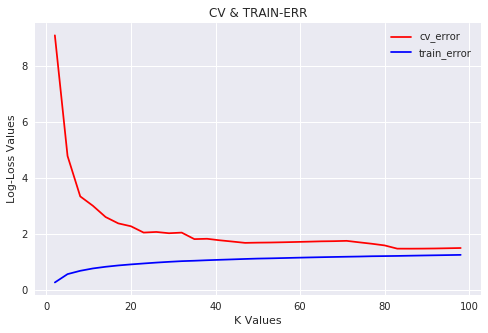

In [100]:
knn_model('Training', 'OneHotEncode', vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* From the log loss curve best fit K for this model seems near to 80. And I'm taking K = 82 as best fit hyper-parameter.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 1.181890914488354
Log-Loss for Test-set is : 1.226381355493204
Train Accuracy is : 0.4691708008504607
Test Accuracy is : 0.46292585170340683
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


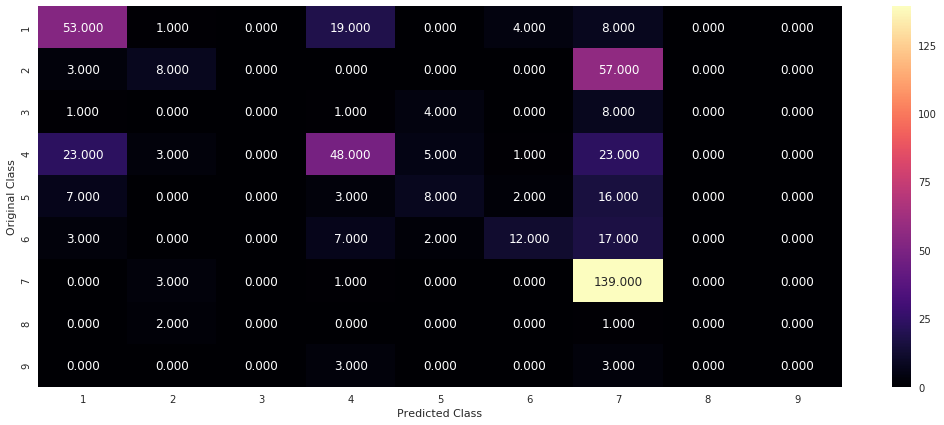

---------------------------------------- PRECISION-MATRIX ----------------------------------------


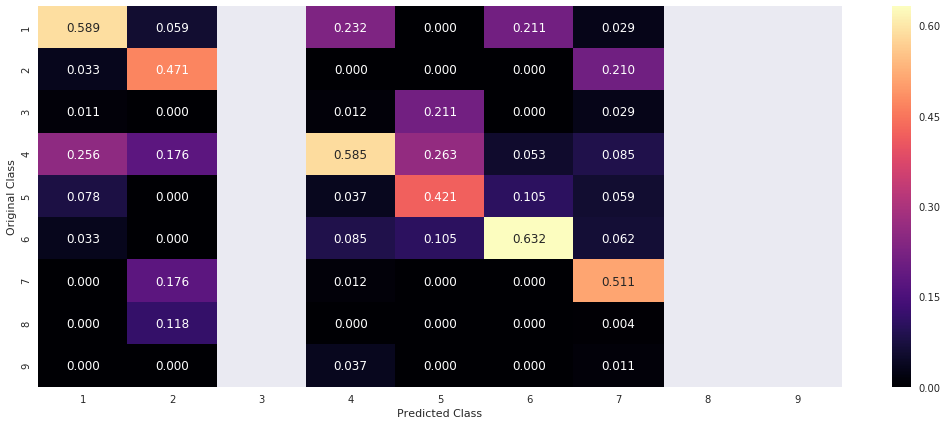

---------------------------------------- RECALL-MATRIX ----------------------------------------


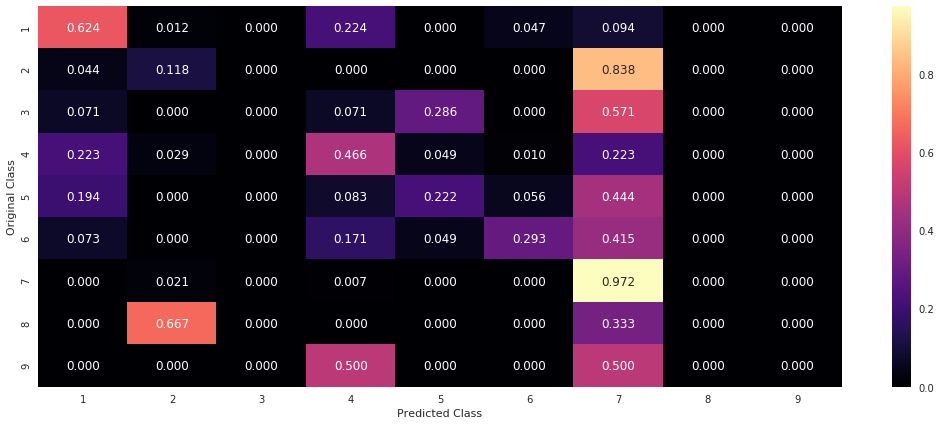

In [102]:
knn_model('Testing', 'OneHotEncode', 82, ngram = 'Unigram')

#### Observation:
* For TFIDF(Unigram with max_feature = 1000) representation and onehotencoding the KNN model performed pretty well. It resulted in 1.18 log-loss for training-set and 1.22 for test-set. 
* But minority classes suffer as they are not involved in precision and recall matrix. 
* From precision matrix the diagonal values are pretty high and but the recall matrix does not look great as the majority class i.e class 7 dominates other classes except class 1 and 4.

### 8.2.2 ResponseEncode

### [A] Log Loss Curve

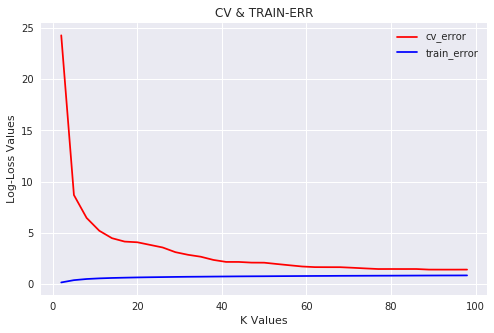

In [103]:
knn_model('Training', 'ResponseEncode')

#### Observation:
* From the log loss curve best fit K for this model seems near to 90. And I'm taking K = 90 as best fit hyper-parameter.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.8349939723291258
Log-Loss for Test-set is : 1.4289668232134702
Train Accuracy is : 0.32282069454287743
Test Accuracy is : 0.5210420841683367
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


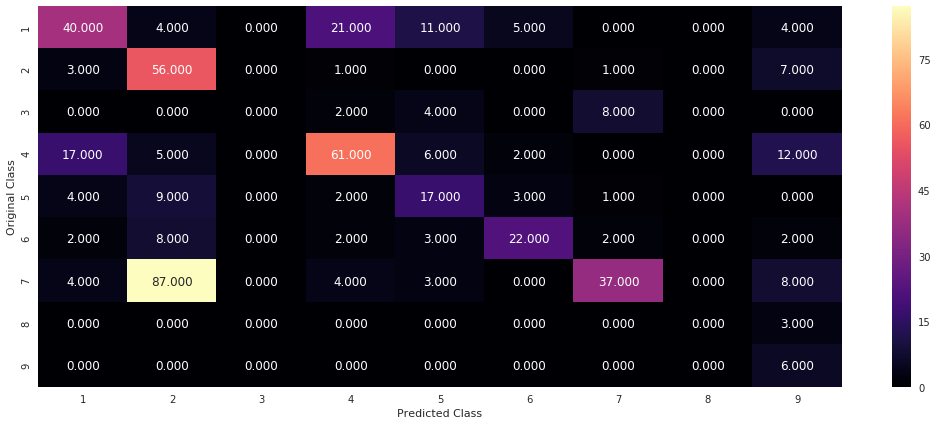

---------------------------------------- PRECISION-MATRIX ----------------------------------------


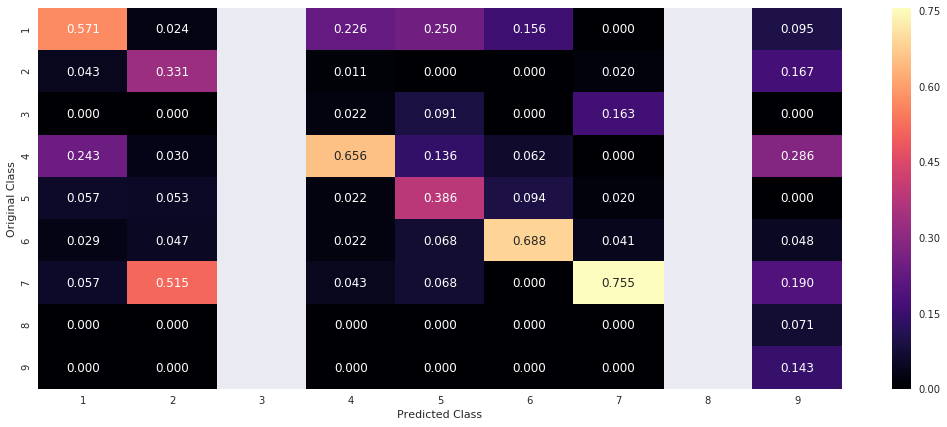

---------------------------------------- RECALL-MATRIX ----------------------------------------


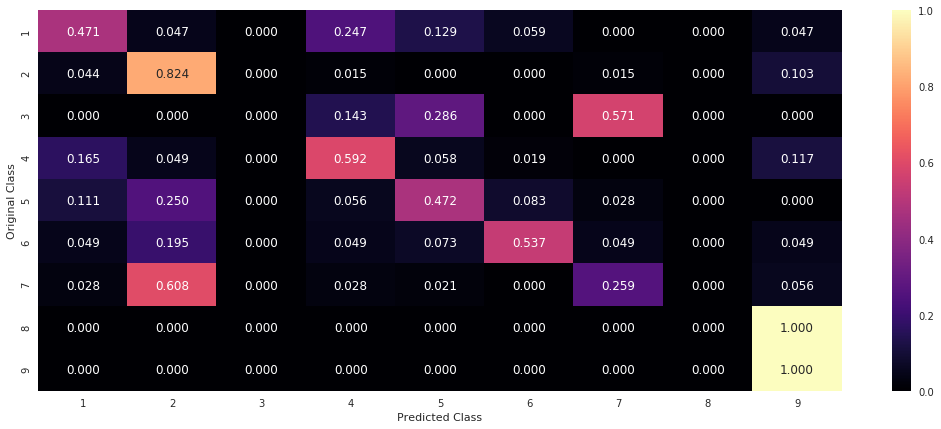

In [110]:
knn_model('Testing', 'ResponseEncode', 90)

#### Observation:
* For response encoding the KNN model performed pretty well except that it overfits the data, as the train loss is 0.83 where as the test loss is 1.43.
* The minority class 3 and 8 are not at all predicted. 
* Both precision and recall matrix seems reasonable except for some classes.

### [C] Incorrectly Classified Point

In [112]:
knn_query(90, 12, 'ResponseEncode')

Predicted Class :  2
Actual Class :  7
----------------------------------------
The  90  nearest neighbours of the test points belongs to classes [2 5 2 2 4 2 7 7 4 1 4 7 2 1 2 7 4 2 7 5 5 5 7 7 2 2 4 4 2 7 7 2 2 2 7 2 2
 2 4 7 7 4 2 2 7 2 2 7 7 2 2 6 2 2 7 1 7 7 6 6 5 5 2 2 2 4 8 7 2 8 4 1 7 2
 7 1 7 4 7 7 5 2 1 1 2 2 7 2 1 2]
Fequency of nearest points : Counter({2: 34, 7: 25, 4: 11, 1: 8, 5: 7, 6: 3, 8: 2})


### [D] Correctly Classified Point

In [113]:
knn_query(90, 1, 'ResponseEncode')

Predicted Class :  2
Actual Class :  2
----------------------------------------
The  90  nearest neighbours of the test points belongs to classes [2 5 2 2 2 7 7 4 1 4 2 7 2 2 1 2 2 7 4 7 4 4 6 7 2 2 2 2 7 2 2 2 2 7 7 2 7
 7 2 7 2 2 2 2 2 2 5 5 5 7 7 2 2 2 7 7 2 2 2 6 8 7 7 6 4 6 1 7 4 7 7 2 7 6
 7 7 2 7 4 1 7 7 1 7 2 2 4 8 2 1]
Fequency of nearest points : Counter({2: 36, 7: 28, 4: 9, 1: 6, 6: 5, 5: 4, 8: 2})


### 8.3 Logistic Regression

In [47]:
def logistic_model(operation, encode_type, weight = None, best_alpha = None, vectorizer = None, ngram = None):
    
    alpha = alpha = [10 ** x for x in range(-6, 3)]
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for a in alpha:
            clf = SGDClassifier(class_weight = weight, alpha = a, penalty = 'l2', loss = 'log', n_jobs = -1)
            clf.fit(trn_data, train_datay)
            pred_proba_trn = clf.predict_proba(trn_data)
            pred_proba_trn = np.nan_to_num(pred_proba_trn)
            pred_proba_cv = clf.predict_proba(cv_data)
            pred_proba_cv = np.nan_to_num(pred_proba_cv)
            train_err.append(log_loss(train_datay, pred_proba_trn))
            cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare(train_err, cv_err, alpha, 'Alpha')
    else:
        clf = SGDClassifier(class_weight = weight, alpha = best_alpha, penalty = 'l2', loss = 'log', n_jobs = -1)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type, vectorizer, ngram)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        pred_proba_trn = clf.predict_proba(trn_data)
        pred_proba_trn = np.nan_to_num(pred_proba_trn)
        pred_proba_tst = clf.predict_proba(tst_data)
        pred_proba_tst = np.nan_to_num(pred_proba_tst)
        trn_err = clf.score(trn_data, train_y)
        tst_err = clf.score(tst_data, test_y)
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [39]:
def lr_query(best_alpha, query_indx, weight = None, vectorizer = None, ngram = None):

    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'OneHotEncode', vectorizer, ngram)
    clf = SGDClassifier(class_weight = weight, alpha = best_alpha, penalty = 'l2', loss = 'log', n_jobs = -1)
    clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    print("Predicted Class Probabilities:", np.round(clf.predict_proba(tst_data.iloc[query_indx].reshape(1, -1)), 4))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    sorted_indices = (-clf.coef_[pred_cls - 1]).argsort()[:, :num_feature]
    imp_features = np.take(tst_data.columns, sorted_indices)
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in np.unique(train_x['Gene']):
                print('Feature from Gene :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            elif tst_data.columns[i] in np.unique(train_x['Variation']):
                print('Feature from Variation :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            else:
                print('Feature from TEXT',tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
    present_word = []
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in test_x['TEXT'].iloc[query_indx]:
                present_word.append(tst_data.columns[i])
    print('These Texts are present in the given query : ')
    print(present_word)

### 8.3.1 Bag of Word (Unigram)

### [A] Log Loss Curve

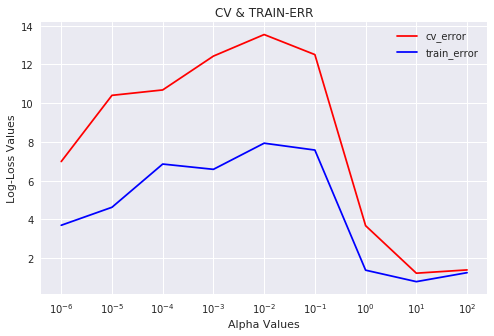

In [48]:
logistic_model('Training', 'OneHotEncode', vectorizer = 'CountVectorizer', ngram = 'Unigram')

#### Observation:
* From the log loss curve best fit alpha for this model seems near 10. And I'm taking alpha = 10 as best fit hyper-parameter.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.8593227587406117
Log-Loss for Test-set is : 1.2235696774569953
Train Accuracy is : 0.7437987243090007
Test Accuracy is : 0.6232464929859719
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


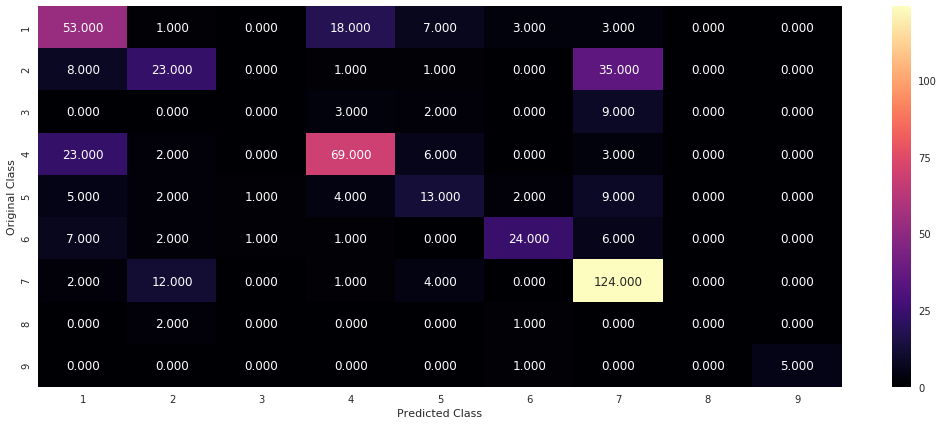

---------------------------------------- PRECISION-MATRIX ----------------------------------------


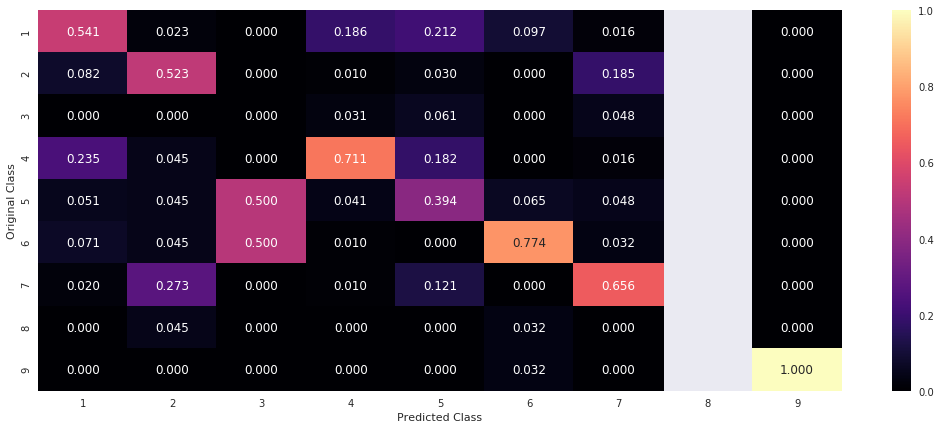

---------------------------------------- RECALL-MATRIX ----------------------------------------


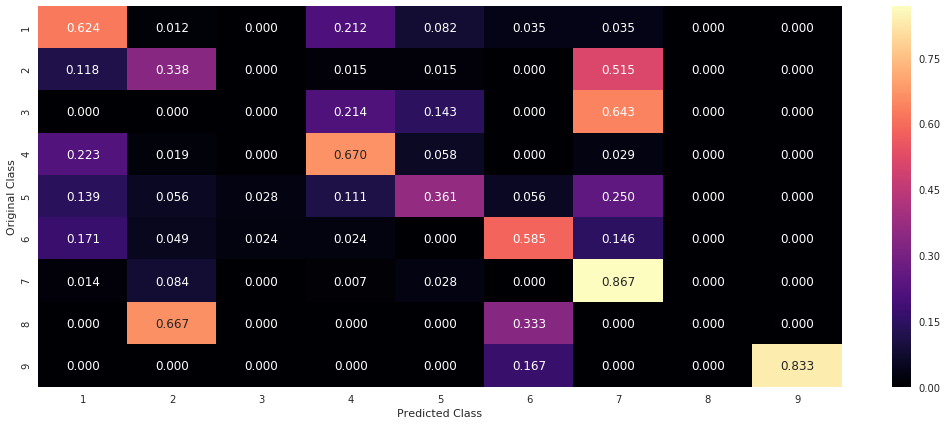

In [49]:
logistic_model('Testing', 'OneHotEncode', best_alpha = 10, vectorizer = 'CountVectorizer', ngram = 'Unigram')

#### Observation:
* This model performed pretty well except that it overfits the data slightly for even best-fit alpha, as the train loss is 0.86 where as the test loss is 1.22.
* The minority class 8 is not at all predicted. 
* Except for class 3, 5 and 8 the precision matrix's diagonal value seems reasonable. From recall matrix it seems the majority class i,e 7 dominates the prediction to some extent.

### 8.3.2 Bag of Word (Unigram) with 'balanced' weight

### [A] Log Loss Curve

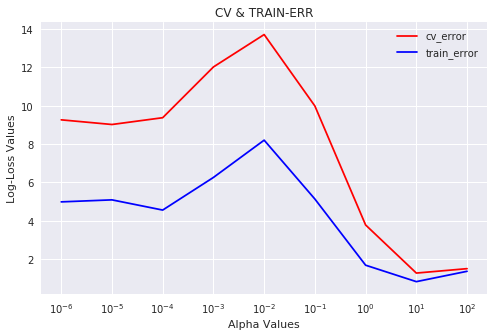

In [50]:
logistic_model('Training', 'OneHotEncode', weight = 'balanced', vectorizer = 'CountVectorizer', ngram = 'Unigram')

#### Observation:
* From the log loss curve best fit alpha for this model seems near 10. And I'm taking alpha = 10 as best fit hyper-parameter.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.9109665028829367
Log-Loss for Test-set is : 1.245302308393737
Train Accuracy is : 0.7129695251594613
Test Accuracy is : 0.5891783567134269
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


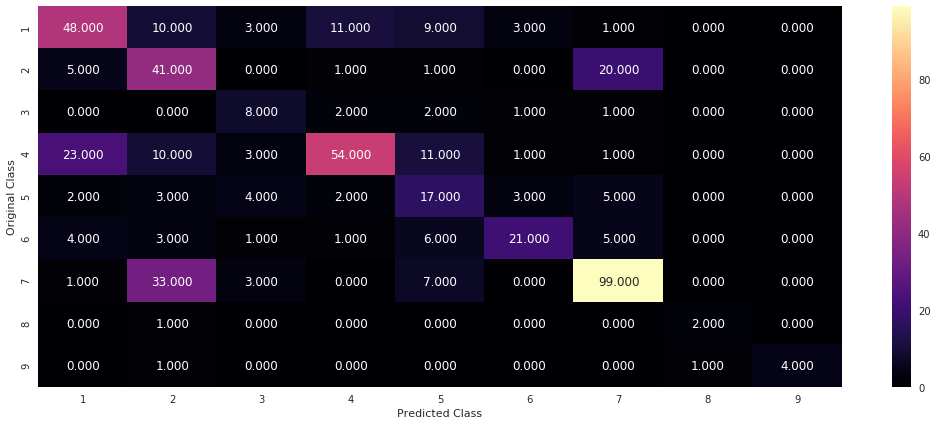

---------------------------------------- PRECISION-MATRIX ----------------------------------------


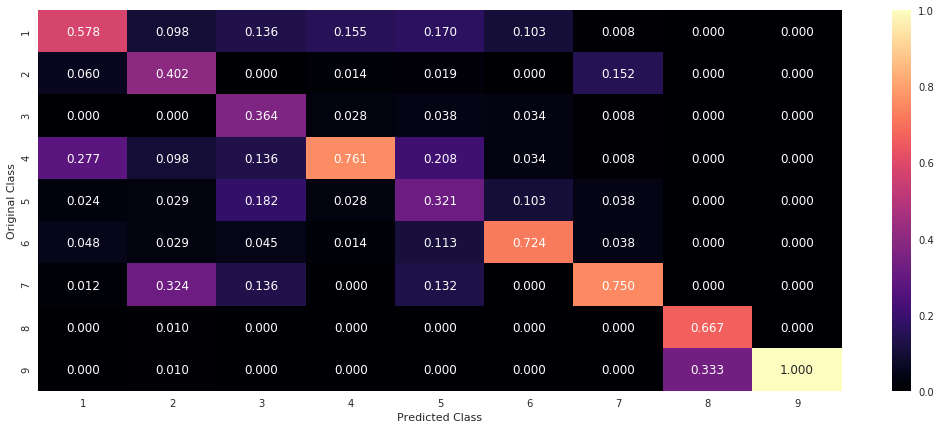

---------------------------------------- RECALL-MATRIX ----------------------------------------


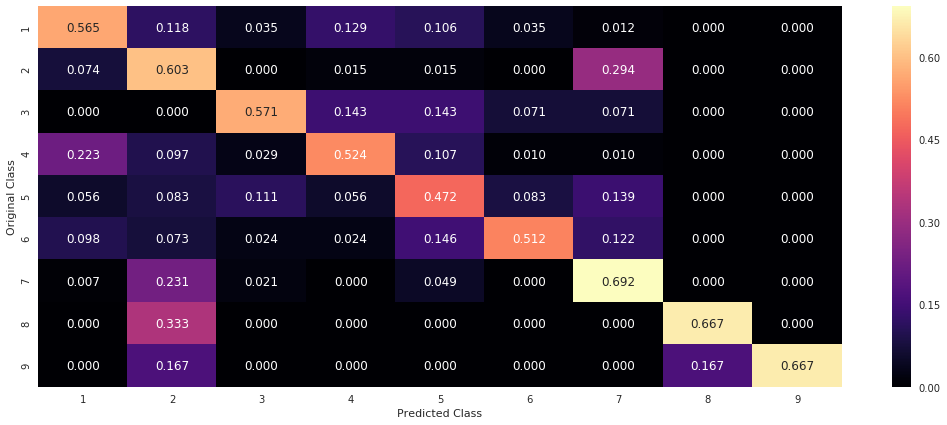

In [53]:
logistic_model('Testing', 'OneHotEncode', weight = 'balanced', best_alpha = 10, vectorizer = 'CountVectorizer', ngram = 'Unigram')

#### Observation:
* After using balanced weight the model performed better than the previous one. It managed to reduce the error gape between train and test error a little bit.
* All the classes got predicted.
* Both precision and recall matrix's diagonal values seems impressive as they are high among the columns and rows respectively. 

### 8.3.3 TFIDF (Unigram)

### [A] Log Loss Curve

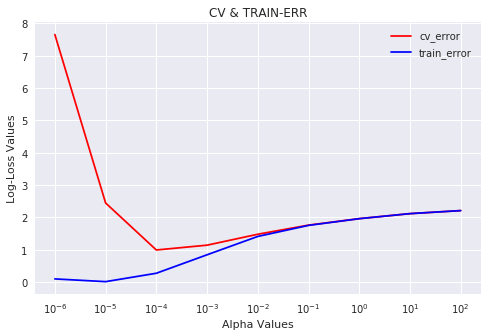

In [54]:
logistic_model('Training', 'OneHotEncode', vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* From the log loss curve best fit alpha for this model seems near 0.001. And I'm taking alpha = 0.001 as best fit hyper-parameter.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.879995610652571
Log-Loss for Test-set is : 1.0877708253021183
Train Accuracy is : 0.7671863926293409
Test Accuracy is : 0.6613226452905812
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


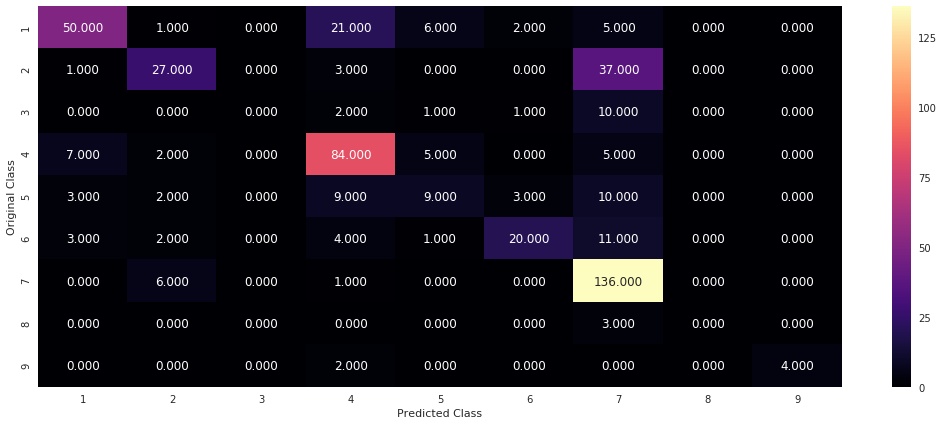

---------------------------------------- PRECISION-MATRIX ----------------------------------------


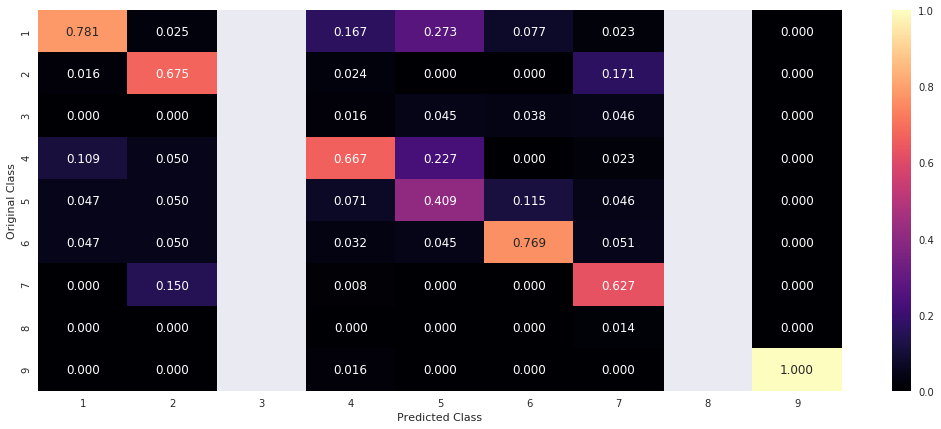

---------------------------------------- RECALL-MATRIX ----------------------------------------


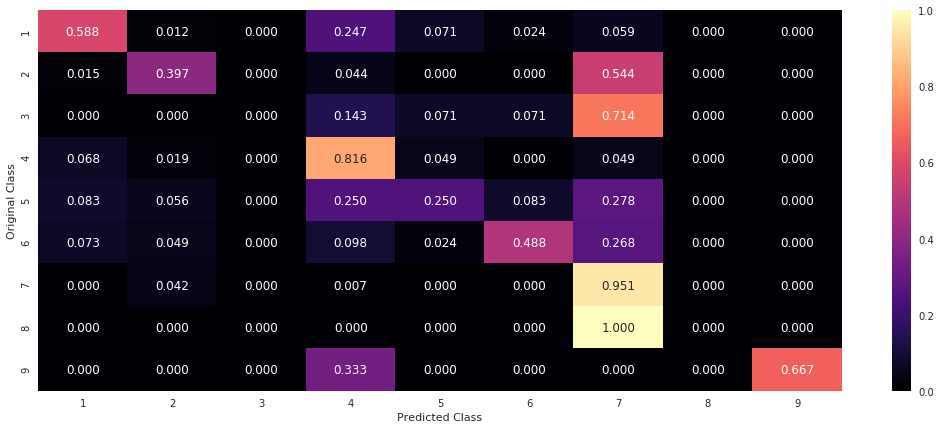

In [58]:
logistic_model('Testing', 'OneHotEncode', best_alpha = 0.001, vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* In terms of log loss the model performed better than the BoW representation but from recall matrix it seems the class 7 dominates some other classes.
* The minority class 3 and 8 are not at all predicted.

### 8.3.4 TFIDF (Unigram) with 'balanced' weight

### [A] Log Loss Curve

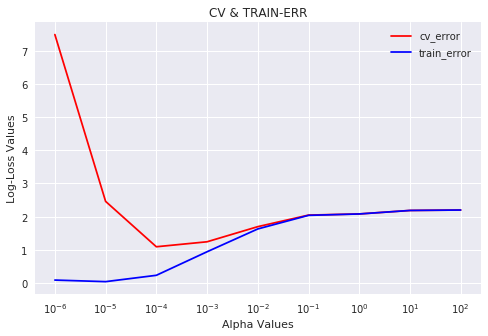

In [59]:
logistic_model('Training', 'OneHotEncode', weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* From the log loss curve best fit alpha for this model seems near 0.001. And I'm taking alpha = 0.001 as best fit hyper-parameter.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.9491341270386794
Log-Loss for Test-set is : 1.1522299562745295
Train Accuracy is : 0.7732104890148831
Test Accuracy is : 0.6432865731462926
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


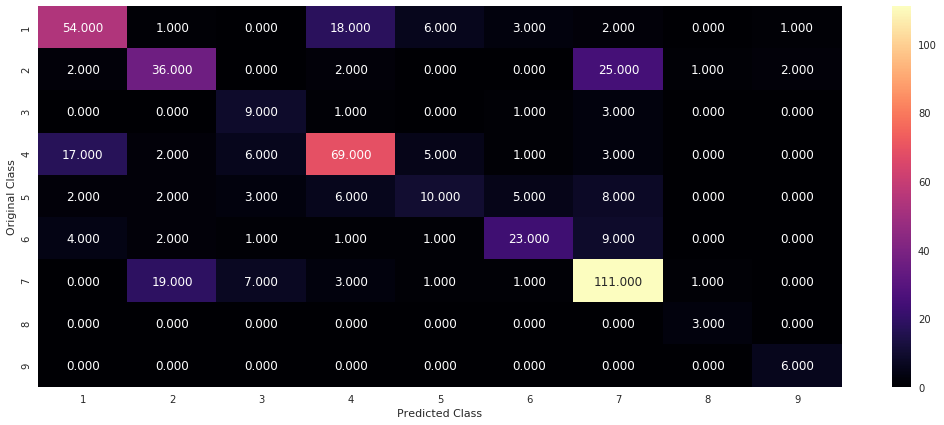

---------------------------------------- PRECISION-MATRIX ----------------------------------------


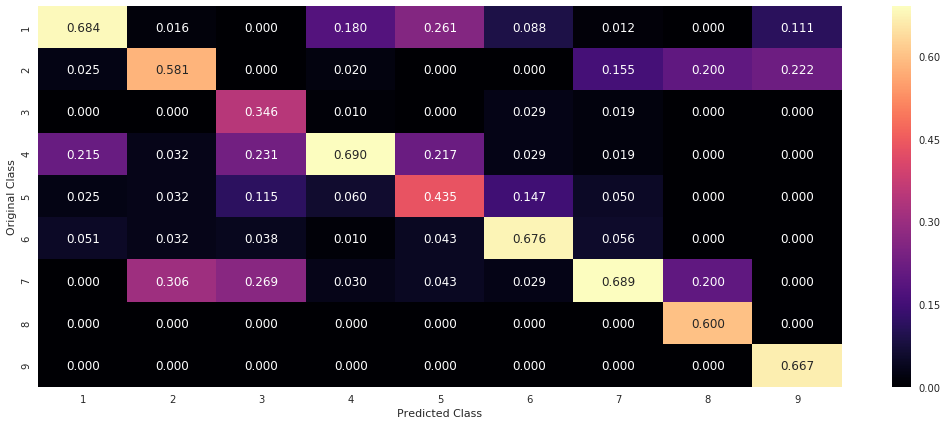

---------------------------------------- RECALL-MATRIX ----------------------------------------


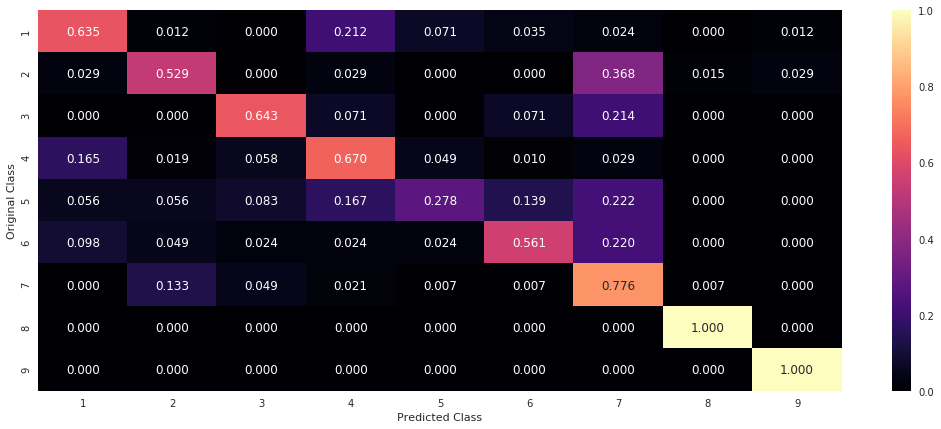

In [60]:
logistic_model('Testing', 'OneHotEncode', weight = 'balanced', best_alpha = 0.001, vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* After using balanced weight the model's log loss increased by 0.07. But both precision and recall matrix's diagonal values seems impressive as they are high among the columns and rows respectively.
* And all the classes got predicted.

### 8.3.5 TFIDF (Bigram)

### [A] Log Loss Curve

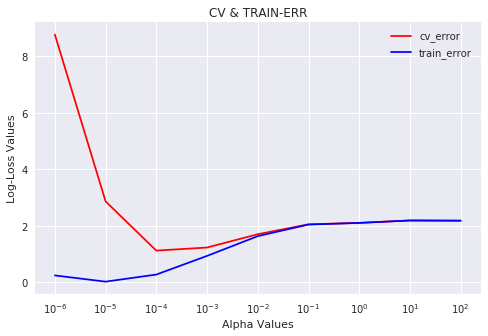

In [61]:
logistic_model('Training', 'OneHotEncode', weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Bigram')

#### Observation:
* From the log loss curve best fit alpha for this model seems near 0.001. And I'm taking alpha = 0.001 as best fit hyper-parameter.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.974640218230672
Log-Loss for Test-set is : 1.1743610619838072
Train Accuracy is : 0.77462792345854
Test Accuracy is : 0.6432865731462926
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


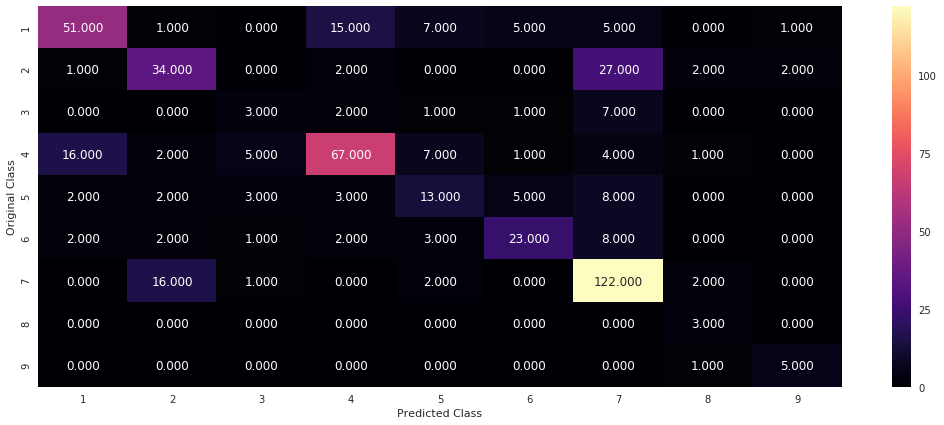

---------------------------------------- PRECISION-MATRIX ----------------------------------------


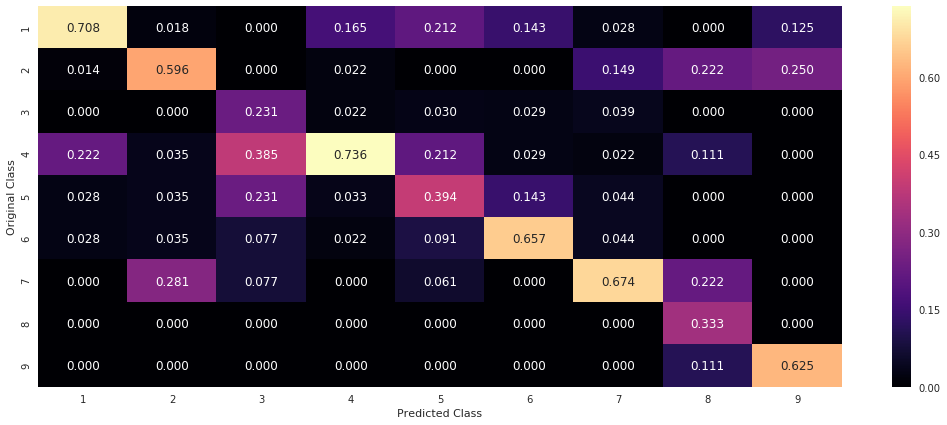

---------------------------------------- RECALL-MATRIX ----------------------------------------


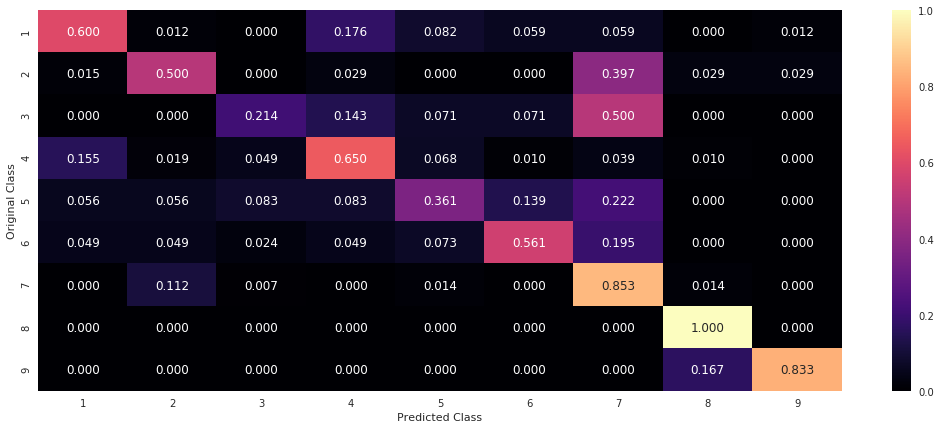

In [62]:
logistic_model('Testing', 'OneHotEncode', weight = 'balanced', best_alpha = 0.001, vectorizer = 'TFIDF', ngram = 'Bigram')

#### Observation:
* Trying the model with TFIDF(Bigram) did not help much in lowering the log loss and the class 3 also got low value for both precision and recall in it's diagonal. 

### [C] Incorrectly Classified Point

In [69]:
lr_query(0.001, 10, vectorizer = 'TFIDF', ngram = 'Unigram')

Predicted Class Probabilities: [[0.2084 0.0554 0.0278 0.3334 0.218  0.0727 0.0679 0.0051 0.0113]]
Predicted Class :  4
Actual Class :  5
----------------------------------------
Feature from Gene : PTEN 0
Feature from Gene : CDKN2A 0
Feature from Gene : NF1 0
Feature from TEXT pten 0.0
Feature from Gene : RUNX1 0
Feature from Gene : KEAP1 0
Feature from Gene : STK11 0
Feature from Gene : PIK3R1 0
Feature from Gene : VHL 0
Feature from Gene : CDKN2B 0
Feature from Gene : CBL 0
Feature from Gene : MAP2K4 0
Feature from Gene : SPOP 0
Feature from Gene : MSH2 0
Feature from TEXT p16ink4a 0.0
Feature from Gene : PTPRT 0
Feature from TEXT spop 0.0
Feature from Gene : TP53 0
Feature from Gene : TGFBR1 0
Feature from TEXT cbl 0.0
Feature from Gene : SMARCA4 0
Feature from Gene : TSC2 0
Feature from Gene : FBXW7 0
Feature from TEXT tgf 0.0
Feature from Gene : BAP1 0
Feature from TEXT smad4 0.0
Feature from Gene : PPP6C 0
Feature from TEXT mkk4 0.0
Feature from TEXT lkb1 0.0
Feature from TEXT br

#### Observation:
* Here is an example of incorrect classification by our model.
* The important features(related to the predicted) are listed along with the associated values; the features with value 0 are not present in the queried data point. 
* The listed words are found in the query text.

### [D] Correctly Classified Point 

In [66]:
lr_query(0.001, 30, vectorizer = 'TFIDF', ngram = 'Unigram')

Predicted Class Probabilities: [[0.0816 0.2265 0.0154 0.1434 0.0309 0.0341 0.4535 0.0059 0.0088]]
Predicted Class :  7
Actual Class :  7
----------------------------------------
Feature from Gene : NFE2L2 0
Feature from Gene : CTNNB1 0
Feature from Gene : JAK1 0
Feature from TEXT egfr 0.004921755479855282
Feature from Gene : PDGFRA 0
Feature from Gene : KRAS 0
Feature from TEXT cells 0.021058646484537525
Feature from Gene : FLT3 0
Feature from TEXT flt3 0.0
Feature from Gene : RAC1 0
Feature from TEXT raf 0.020156871289111096
Feature from Gene : ALK 0
Feature from Gene : KIT 0
Feature from Gene : MET 0
Feature from TEXT ras 0.0045106461223141155
Feature from Gene : ESR1 0
Feature from Gene : PIK3CA 0
Feature from Gene : MAP2K1 0
Feature from Gene : FGFR1 0
Feature from Gene : AKT2 0
Feature from TEXT catenin 0.19945022159699952
Feature from Gene : NTRK1 0
Feature from Gene : AR 0
Feature from Gene : CARD11 0
Feature from TEXT erbb4 0.0
Feature from TEXT akt 0.0
Feature from TEXT nrf2 0

#### Observation:
* Here is an example of correct classification by our model.
* The important features(related to the predicted) are listed along with the associated values; the features with value 0 are not present in the queried data point. 
* The listed words are found in the query text.

### 8.4 Linear Support Vector Classifier 

In [70]:
def svm_model(operation, encode_type, weight = None, best_c = None, vectorizer = None, ngram = None):
    
    C = [10 ** x for x in range(-6, 3)]
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for c in C:
            clf = SGDClassifier(class_weight = weight, alpha = c, penalty = 'l2', loss = 'hinge', n_jobs = -1)
            clf.fit(trn_data, train_datay)
            sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
            sig_clf.fit(trn_data, train_datay)
            pred_proba_trn = sig_clf.predict_proba(trn_data)
            pred_proba_cv = sig_clf.predict_proba(cv_data)
            train_err.append(log_loss(train_datay, pred_proba_trn))
            cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare(train_err, cv_err, C, 'C')
    else:
        clf = SGDClassifier(class_weight = weight, alpha = best_c, penalty = 'l2', loss = 'hinge', n_jobs = -1)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(trn_data, train_y)
        pred_proba_trn = sig_clf.predict_proba(trn_data)
        pred_proba_tst = sig_clf.predict_proba(tst_data)
        trn_err = clf.score(trn_data, train_y)
        tst_err = clf.score(tst_data, test_y)
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [85]:
def svm_query(best_c, query_indx, weight = None, vectorizer = None, ngram = None):

    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'OneHotEncode', vectorizer, ngram)
    clf = SGDClassifier(class_weight = weight, alpha = best_c, penalty = 'l2', loss = 'hinge', n_jobs = -1)
    clf.fit(trn_data, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = sig_clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(tst_data.iloc[query_indx].reshape(1, -1)), 4))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    sorted_indices = (-clf.coef_[pred_cls - 1]).argsort()[:, :num_feature]
    imp_features = np.take(tst_data.columns, sorted_indices)
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in np.unique(train_x['Gene']):
                print('Feature from Gene :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            elif tst_data.columns[i] in np.unique(train_x['Variation']):
                print('Feature from Variation :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            else:
                print('Feature from TEXT',tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
    present_word = []
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in test_x['TEXT'].iloc[query_indx]:
                present_word.append(tst_data.columns[i])
    print('These Texts are present in the given query : ')
    print(present_word)

### [A] Log Loss Curve

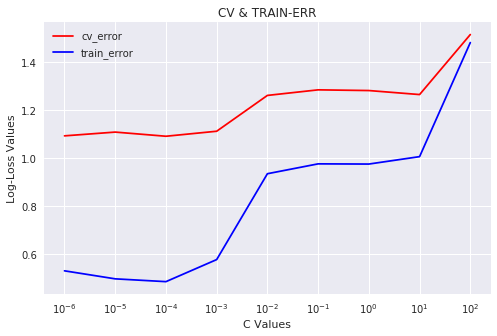

In [74]:
svm_model('Training', 'OneHotEncode', weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* From the log loss curve best fit alpha for this model seems near 10. And I'm taking alpha = 10 as best fit hyper-parameter.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 1.1203838749187223
Log-Loss for Test-set is : 1.2631402556164022
Train Accuracy is : 0.7632884479092842
Test Accuracy is : 0.5751503006012024
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


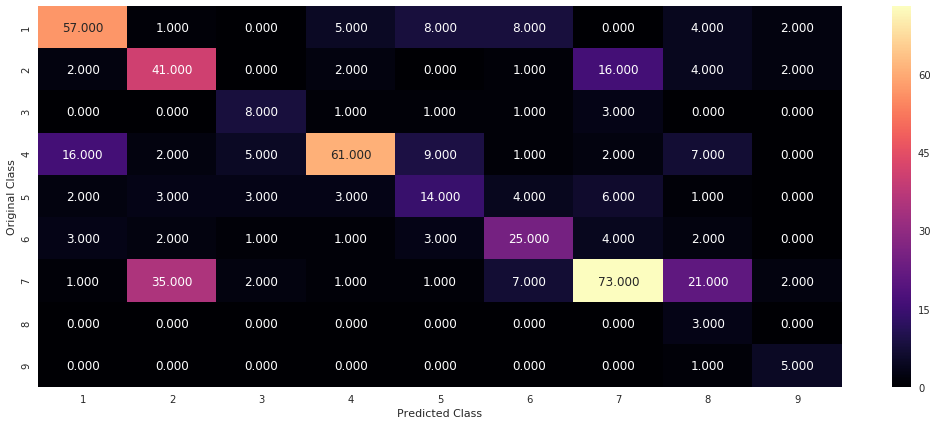

---------------------------------------- PRECISION-MATRIX ----------------------------------------


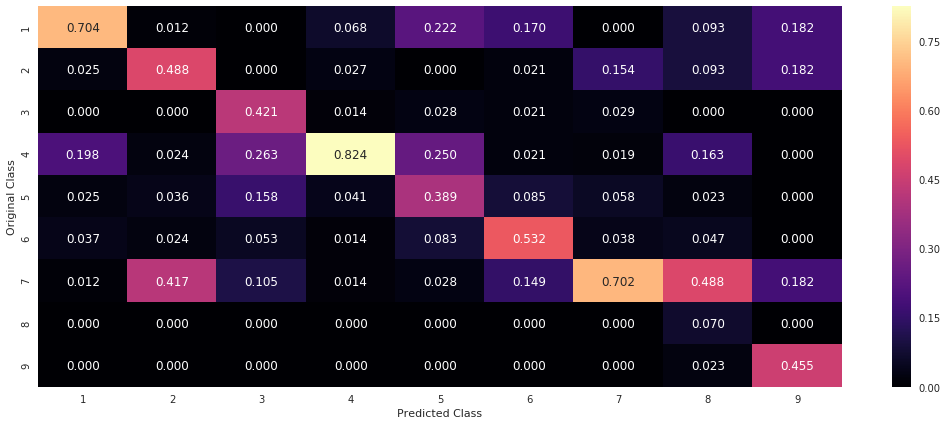

---------------------------------------- RECALL-MATRIX ----------------------------------------


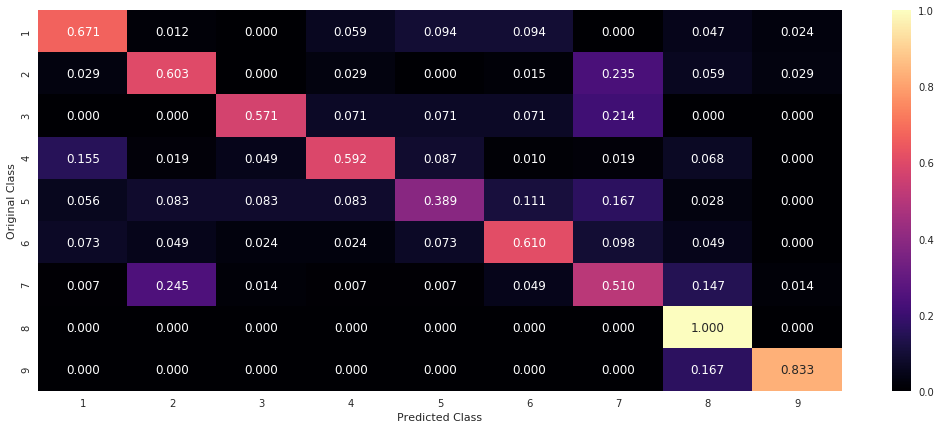

In [77]:
svm_model('Testing', 'OneHotEncode', best_c = 10, weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* The model performed well as it got log loss of 1.12 for train data and 1.26 for test data.
* All the classes got predicted.
* Both precision and recall matrix's diagonal values seems impressive as they are high among the columns and rows respectively. 

### [C] Incorrectly Classified Point 

In [93]:
svm_query(10, 165, weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Unigram')

Predicted Class Probabilities: [[0.0883 0.1124 0.0168 0.1223 0.0435 0.0513 0.5586 0.0034 0.0034]]
Predicted Class :  7
Actual Class :  3
----------------------------------------
Feature from Gene : CTNNB1 0
Feature from Gene : JAK1 0
Feature from Gene : NFE2L2 0
Feature from Gene : FLT3 0
Feature from Gene : RAC1 0
Feature from TEXT jak1 0.0
Feature from TEXT itd 0.0
Feature from Gene : KRAS 0
Feature from TEXT flt3 0.011427761296934812
Feature from TEXT hca 0.0
Feature from Gene : ARAF 0
Feature from Variation : G12V 0
Feature from Gene : MYD88 0
Feature from Gene : FGFR4 0
Feature from Gene : RHEB 0
Feature from Variation : Q61R 0
Feature from Gene : CDK4 0
Feature from TEXT frk 0.0
Feature from Gene : PDGFRA 0
Feature from TEXT hggs 0.0
Feature from TEXT crt 0.0
Feature from TEXT nr 0.0
Feature from TEXT d835 0.0
Feature from TEXT 06463922 0.0
Feature from TEXT acvr1 0.0
Feature from Gene : MAPK1 0
Feature from Variation : TMPRSS2-ETV1_Fusion 0
Feature from Variation : G12D 0
Featur

#### Observation:
* Here is an example of incorrect classification by our model.
* The important features(related to the predicted) are listed along with the associated values; the features with value 0 are not present in the queried data point. 
* The listed words are found in the query text.

### [D] Correctly Classified Point 

In [95]:
svm_query(10, 91, weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Unigram')

Predicted Class Probabilities: [[0.4198 0.0669 0.0106 0.18   0.0362 0.0466 0.2343 0.0027 0.0028]]
Predicted Class :  1
Actual Class :  1
----------------------------------------
Feature from Variation : Truncating_Mutations 0
Feature from Variation : Deletion 0
Feature from Gene : ERCC2 1
Feature from TEXT ercc2 0.8991160572534489
Feature from Gene : FOXA1 0
Feature from Gene : PPP2R1A 0
Feature from TEXT ptp 0.0
Feature from Gene : RASA1 0
Feature from TEXT pp2a 0.0
Feature from TEXT aggregation 0.0
Feature from TEXT foxa1 0.0
Feature from TEXT hla 0.0
Feature from TEXT oc 0.0
Feature from TEXT hotspots 0.0
Feature from TEXT cic 0.0
Feature from TEXT dsred 0.0
Feature from TEXT prb 0.0
Feature from Gene : CREBBP 0
Feature from Gene : CIC 0
Feature from TEXT bc 0.0
Feature from TEXT fniii 0.0
Feature from TEXT smad3 0.0
Feature from TEXT asxl1 0.0
Feature from TEXT crebbp 0.0
Feature from TEXT rasa1 0.0
Feature from Gene : CARM1 0
Feature from Gene : MGA 0
Feature from Gene : BCL10 0
F

#### Observation:
* Here is an example of correct classification by our model.
* The important features(related to the predicted) are listed along with the associated values; the features with value 0 are not present in the queried data point. 
* The listed words are found in the query text.

### 8.5 Random Forest Classifier 

In [29]:
def err_output(train_err, cv_err, depths, n_bases):
    print('Train Error :')
    i = 0
    for b in n_bases:
        for d in depths:
            print('Log Loss for depth {0} and no. of base {1} is {2}'.format(d, b, train_err[i]))
            i += 1
    print('\n')       
    print('Cross-Validation Error :')
    i = 0
    for b in n_bases:
        for d in depths:
            print('Log Loss for depth {0} and no. of base {1} is {2}'.format(d, b, cv_err[i]))
            i += 1

In [30]:
def rf_model(operation, encode_type, weight = None, best_depth = None, best_base = None, vectorizer = None, ngram = None):
    
    n_base = np.array([5, 10, 25, 50, 100, 250, 500, 750, 1000])
    depth = np.arange(2, 21, 3)
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for b in n_base:
            for d in depth:
                clf = RandomForestClassifier(n_estimators = b, max_depth = d, n_jobs = -1)
                clf.fit(trn_data, train_datay)
                sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
                sig_clf.fit(trn_data, train_datay)
                pred_proba_trn = sig_clf.predict_proba(trn_data)
                pred_proba_cv = sig_clf.predict_proba(cv_data)
                train_err.append(log_loss(train_datay, pred_proba_trn))
                cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_output(train_err, cv_err, depth, n_base)
    else:
        clf = RandomForestClassifier(n_estimators = best_base, max_depth = best_depth, n_jobs = -1)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(trn_data, train_y)
        pred_proba_trn = sig_clf.predict_proba(trn_data)
        pred_proba_tst = sig_clf.predict_proba(tst_data)
        trn_err = clf.score(trn_data, train_y)
        tst_err = clf.score(tst_data, test_y)
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [31]:
def rf_query(best_depth, best_base, query_indx, weight = None, vectorizer = None, ngram = None):

    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'OneHotEncode', vectorizer, ngram)
    clf = RandomForestClassifier(n_estimators = best_base, max_depth = best_depth, n_jobs = -1)
    clf.fit(trn_data, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(tst_data.iloc[query_indx].reshape(1, -1)), 4))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    sorted_indices = np.argsort(-clf.feature_importances_)[:100]
    imp_features = np.take(tst_data.columns, sorted_indices)
    for i in sorted_indices:
        if tst_data.columns[i] in np.unique(train_x['Gene']):
            print('Feature from Gene :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
        elif tst_data.columns[i] in np.unique(train_x['Variation']):
            print('Feature from Variation :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
        else:
            print('Feature from TEXT',tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
    present_word = []
    for i in sorted_indices:
        if tst_data.columns[i] in test_x['TEXT'].iloc[query_indx]:
            present_word.append(tst_data.columns[i])
    print('These Texts are present in the given query : ')
    print(present_word)

### 8.5.1 TFIDF (Unigram)

### [A] Log Loss 

In [108]:
rf_model('Training', 'OneHotEncode', weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Unigram')

Train Error :
Log Loss for depth 2 and no. of base 5 is 1.423909520502015
Log Loss for depth 5 and no. of base 5 is 1.1833342985789552
Log Loss for depth 8 and no. of base 5 is 0.9045380055015149
Log Loss for depth 11 and no. of base 5 is 0.7222330496333241
Log Loss for depth 14 and no. of base 5 is 0.6849406020755106
Log Loss for depth 17 and no. of base 5 is 0.6921448230658109
Log Loss for depth 20 and no. of base 5 is 0.6785391680991958
Log Loss for depth 2 and no. of base 10 is 1.3735975331726336
Log Loss for depth 5 and no. of base 10 is 1.0709534728867596
Log Loss for depth 8 and no. of base 10 is 0.7901949366933414
Log Loss for depth 11 and no. of base 10 is 0.6491117035788072
Log Loss for depth 14 and no. of base 10 is 0.6131068772932197
Log Loss for depth 17 and no. of base 10 is 0.572388309198026
Log Loss for depth 20 and no. of base 10 is 0.5784161527609716
Log Loss for depth 2 and no. of base 25 is 1.2956201378900856
Log Loss for depth 5 and no. of base 25 is 0.960550360596

#### Observation:
* From train and cv log loss best fit depth seems to be 7 and best fit number of base seems to be 1000.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.8650646782585433
Log-Loss for Test-set is : 1.1069360825546537
Train Accuracy is : 0.6732813607370659
Test Accuracy is : 0.5951903807615231
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


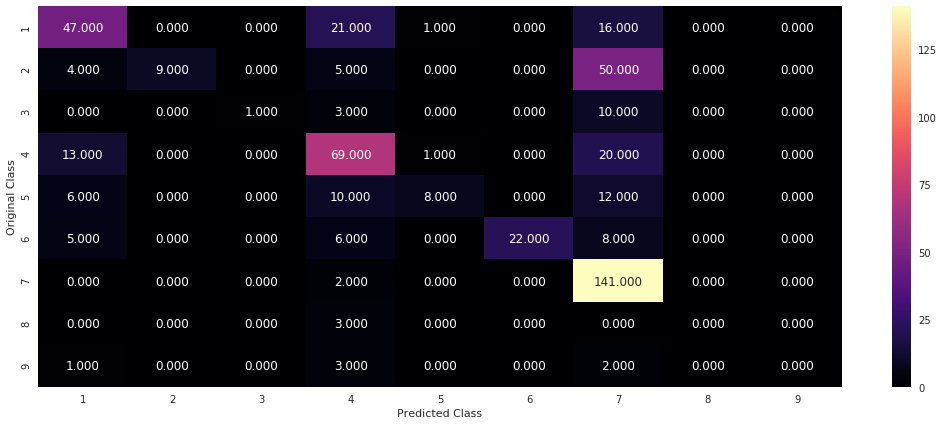

---------------------------------------- PRECISION-MATRIX ----------------------------------------


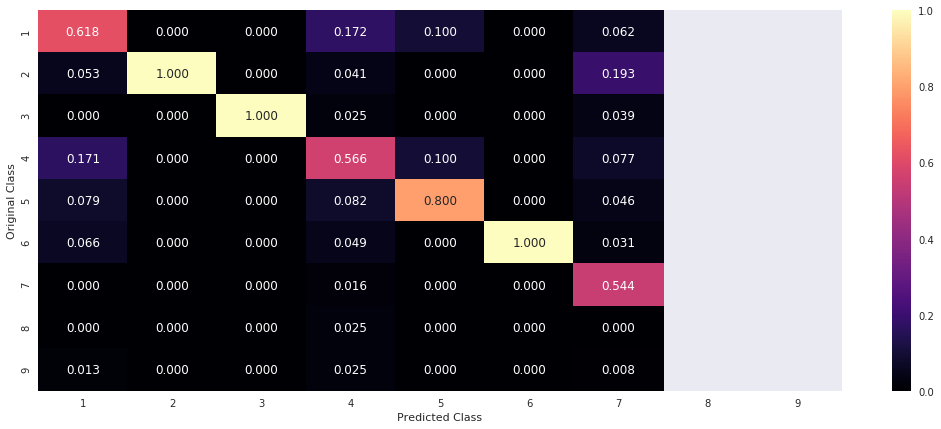

---------------------------------------- RECALL-MATRIX ----------------------------------------


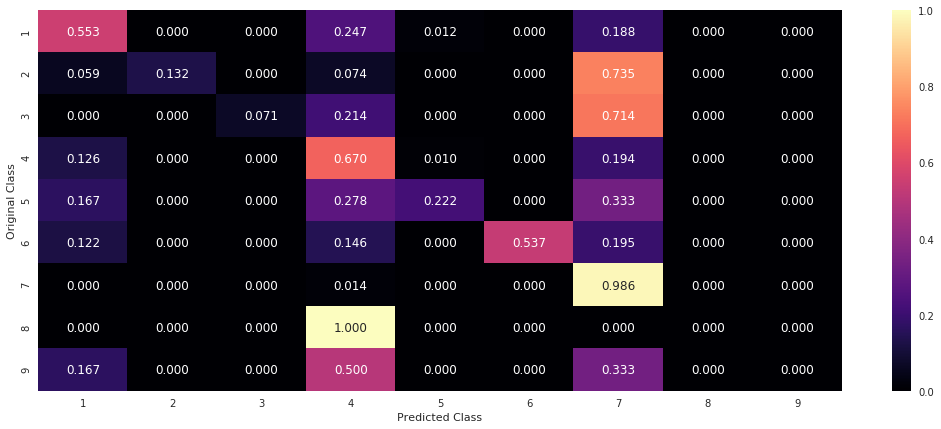

In [113]:
rf_model('Testing', 'OneHotEncode', best_depth = 7, best_base = 1000, weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* The model performed well as it got log loss of 0.86 for train data and 1.10 for test data.
* But the class 8 and 9 are not at all predicted.
* Except that, from recall matrix it seems that majority class like class 7 and class 4 dominate other classes. 

### 8.5.2 TFIDF (Bigram)

### [A] Log Loss 

In [116]:
rf_model('Training', 'OneHotEncode', weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Bigram')

Train Error :
Log Loss for depth 2 and no. of base 5 is 1.4234198330977252
Log Loss for depth 5 and no. of base 5 is 1.1453845691443019
Log Loss for depth 8 and no. of base 5 is 0.9076663000022561
Log Loss for depth 11 and no. of base 5 is 0.7930970607721679
Log Loss for depth 14 and no. of base 5 is 0.7064055487641232
Log Loss for depth 17 and no. of base 5 is 0.6844821313946258
Log Loss for depth 20 and no. of base 5 is 0.6932705165379156
Log Loss for depth 2 and no. of base 10 is 1.389528685046012
Log Loss for depth 5 and no. of base 10 is 1.0551430929001155
Log Loss for depth 8 and no. of base 10 is 0.7942822015090063
Log Loss for depth 11 and no. of base 10 is 0.6514720931353402
Log Loss for depth 14 and no. of base 10 is 0.5947520906246996
Log Loss for depth 17 and no. of base 10 is 0.5823161345487473
Log Loss for depth 20 and no. of base 10 is 0.5677462904787239
Log Loss for depth 2 and no. of base 25 is 1.2883814673215719
Log Loss for depth 5 and no. of base 25 is 0.94999715815

#### Observation:
* From train and cv log loss best fit depth seems to be 6 and best fit number of base seems to be 1000.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.7837977969781064
Log-Loss for Test-set is : 1.0761338264073428
Train Accuracy is : 0.6909992912827781
Test Accuracy is : 0.6072144288577155
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


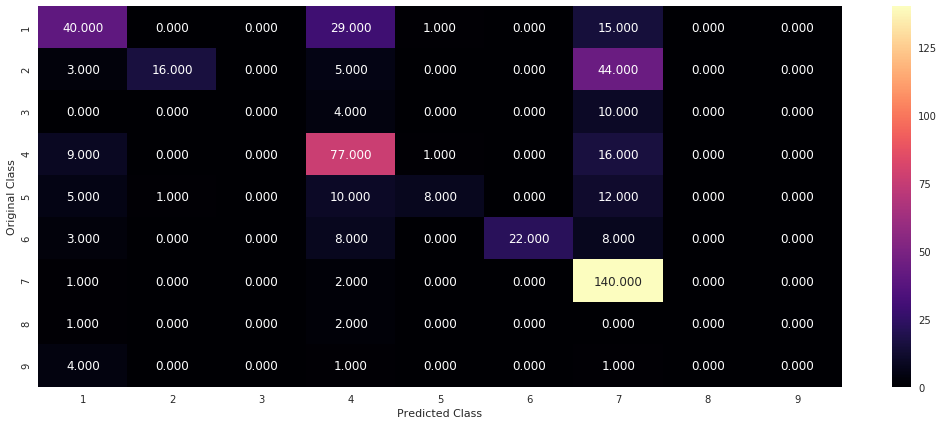

---------------------------------------- PRECISION-MATRIX ----------------------------------------


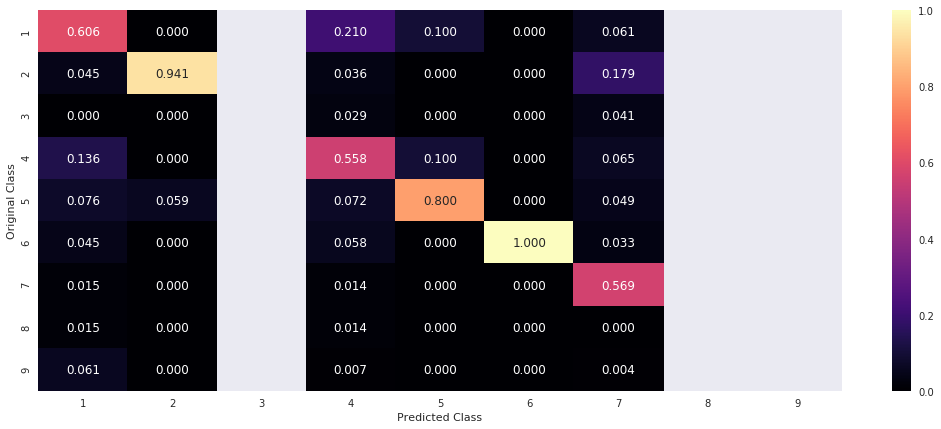

---------------------------------------- RECALL-MATRIX ----------------------------------------


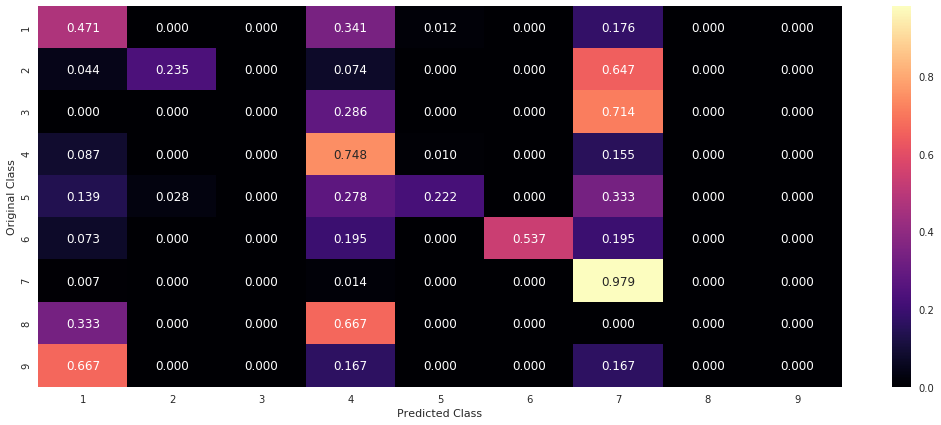

In [118]:
rf_model('Testing', 'OneHotEncode', best_depth = 6, best_base = 1000, weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Bigram')

#### Observation:
* The tfidf vectorizer did not help much as the results are similar to the last one.

### [C] Incorrectly Classified Point 

In [114]:
rf_query(7, 1000, 29, weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Unigram')

Predicted Class Probabilities: [[0.0217 0.1132 0.0166 0.0208 0.0361 0.0265 0.759  0.0038 0.0024]]
Predicted Class :  7
Actual Class :  4
----------------------------------------
Feature from TEXT kinase 0.09094100630092718
Feature from TEXT activating 0.00394561615690696
Feature from TEXT tyrosine 0.08610965413814993
Feature from TEXT activated 0.019958594213383064
Feature from TEXT activation 0.025092967956350895
Feature from TEXT function 0.005907675780984346
Feature from TEXT inhibitors 0.03204564800215728
Feature from TEXT suppressor 0.0088534172664663
Feature from TEXT loss 0.0
Feature from TEXT constitutive 0.0
Feature from TEXT phosphorylation 0.033073895327965015
Feature from TEXT oncogenic 0.09133075309756113
Feature from TEXT treatment 0.029855493022620055
Feature from TEXT brca1 0.0
Feature from TEXT stability 0.0
Feature from TEXT pathogenic 0.0
Feature from TEXT variants 0.0
Feature from TEXT protein 0.01921183426856873
Feature from TEXT missense 0.0
Feature from TEXT inhi

#### Observation:
* Here is an example of incorrect classification by our model.
* The important features(related to the predicted) are listed along with the associated values; the features with value 0 are not present in the queried data point. 
* The listed words are found in the query text.

### [D] Correctly Classified Point

In [120]:
rf_query(7, 1000, 101, weight = 'balanced', vectorizer = 'TFIDF', ngram = 'Unigram')

Predicted Class Probabilities: [[0.0355 0.7105 0.0123 0.027  0.0303 0.024  0.1525 0.0042 0.0036]]
Predicted Class :  2
Actual Class :  2
----------------------------------------
Feature from TEXT kinase 0.0019844192622509643
Feature from TEXT activating 0.023246216375400294
Feature from TEXT suppressor 0.01217096913616337
Feature from TEXT tyrosine 0.0
Feature from TEXT function 0.01740299917923724
Feature from TEXT activation 0.04003977142196789
Feature from TEXT inhibitors 0.012586797392747132
Feature from TEXT loss 0.0063284921501020495
Feature from TEXT activated 0.012542846708719833
Feature from TEXT phosphorylation 0.0007217038565562565
Feature from TEXT constitutive 0.001848870587008109
Feature from TEXT treatment 0.012459464287254673
Feature from TEXT inhibitor 0.005941347199987612
Feature from TEXT activate 0.010549384810619638
Feature from TEXT protein 0.010240957889283907
Feature from TEXT missense 0.0043710491276545025
Feature from TEXT therapy 0.0027044316196719793
Feature

#### Observation:
* Here is an example of correct classification by our model.
* The important features(related to the predicted) are listed along with the associated values; the features with value 0 are not present in the queried data point. 
* The listed words are found in the query text.

### 8.5.3 Response Encode

### [A] Log Loss 

In [126]:
rf_model('Training', 'ResponseEncode', weight = 'balanced')

Train Error :
Log Loss for depth 2 and no. of base 5 is 0.5955019185824153
Log Loss for depth 5 and no. of base 5 is 0.2349637631611637
Log Loss for depth 8 and no. of base 5 is 0.17062081746824573
Log Loss for depth 11 and no. of base 5 is 0.1631997410698491
Log Loss for depth 14 and no. of base 5 is 0.1762290174582257
Log Loss for depth 17 and no. of base 5 is 0.18902646736673903
Log Loss for depth 20 and no. of base 5 is 0.15653827948148927
Log Loss for depth 2 and no. of base 10 is 0.29244009369251905
Log Loss for depth 5 and no. of base 10 is 0.17033812922511937
Log Loss for depth 8 and no. of base 10 is 0.13606674883640657
Log Loss for depth 11 and no. of base 10 is 0.14092001757905456
Log Loss for depth 14 and no. of base 10 is 0.14847071957782734
Log Loss for depth 17 and no. of base 10 is 0.16250282364676338
Log Loss for depth 20 and no. of base 10 is 0.14645711281723695
Log Loss for depth 2 and no. of base 25 is 0.2953859791581436
Log Loss for depth 5 and no. of base 25 is 0.

#### Observation:
* From train and cv log loss best fit depth seems to be 8 and best fit number of base seems to be 1000.

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.04363389978604297
Log-Loss for Test-set is : 1.8992876845461009
Train Accuracy is : 0.9897236002834869
Test Accuracy is : 0.3867735470941884
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


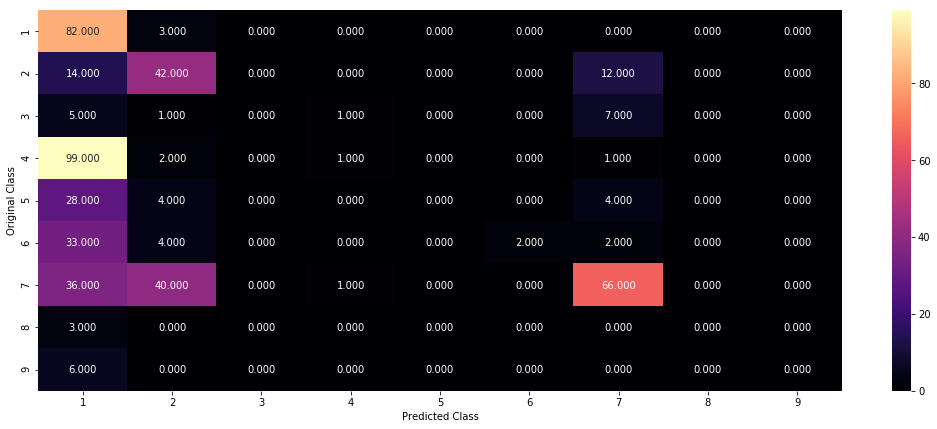

---------------------------------------- PRECISION-MATRIX ----------------------------------------


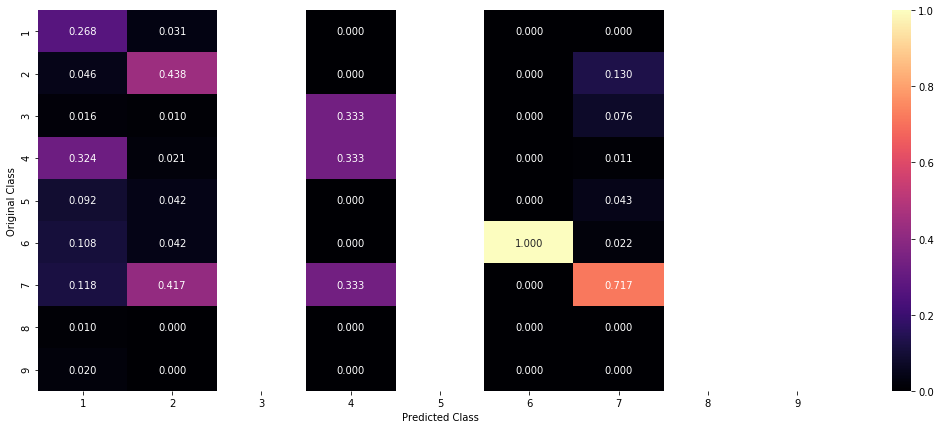

---------------------------------------- RECALL-MATRIX ----------------------------------------


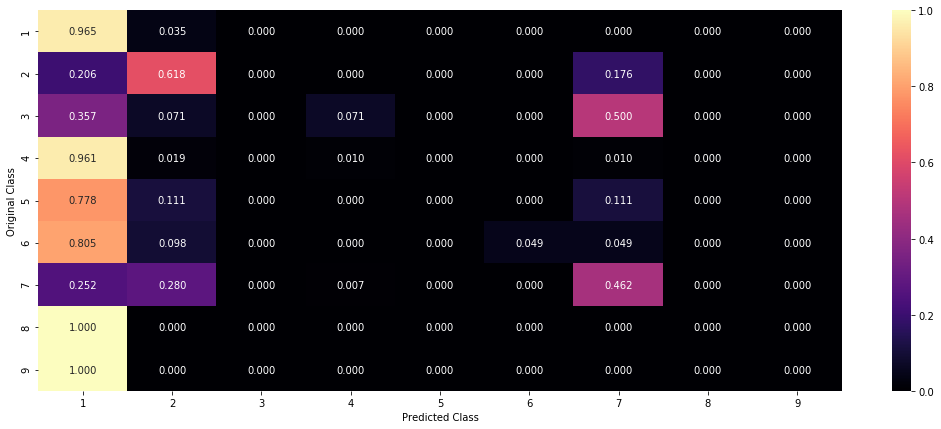

In [37]:
rf_model('Testing', 'ResponseEncode', best_depth = 8, best_base = 1000, weight = 'balanced')

#### Observation:
* Our random forest model easily overfits the response encoded data, that's why the training log loss is only 0.04 and test loss is 1.90.

### 8.6 Stacking Classifier 

In [67]:
def stacking_classifier(operation, encode_type, best_alpha = None, vectorizer = None, ngram = None):
    
    alpha = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]
    if operation == 'Training':
        cv_err = []
        train_err = []
        
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        
        clf1 = SGDClassifier(alpha = 0.001, penalty = 'l2', loss = 'log', class_weight = 'balanced', n_jobs = -1)
        clf1.fit(trn_data, train_datay)
        sig_clf1 = CalibratedClassifierCV(clf1, method = "sigmoid")

        clf2 = SGDClassifier(alpha = 10, penalty='l2', loss='hinge', class_weight='balanced', n_jobs = -1)
        clf2.fit(trn_data, train_datay)
        sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


        clf3 = MultinomialNB(alpha = 100, fit_prior = False)
        clf3.fit(trn_data, train_datay)
        sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

        sig_clf1.fit(trn_data, train_datay)
        print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(crossv_y, sig_clf1.predict_proba(cv_data))))
        sig_clf2.fit(trn_data, train_datay)
        print("Support vector machines : Log Loss: %0.2f" % (log_loss(crossv_y, sig_clf2.predict_proba(cv_data))))
        sig_clf3.fit(trn_data, train_datay)
        print("Naive Bayes : Log Loss: %0.2f" % (log_loss(crossv_y, sig_clf3.predict_proba(cv_data))))
        print("-"*50)
        
        for a in alpha:
            lr = LogisticRegression(penalty = 'l2', C = a, class_weight = 'balanced', n_jobs = -1)
            sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier = lr, use_probas = True)
            sclf.fit(trn_data, train_datay)
            train_err.append(log_loss(train_datay, sclf.predict_proba(trn_data)))
            cv_err.append(log_loss(crossv_y, sclf.predict_proba(cv_data)))
        
        err_compare(train_err, cv_err, alpha, 'Alpha')
    else:
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type, vectorizer, ngram)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
            
        clf1 = SGDClassifier(alpha = 0.001, penalty = 'l2', loss = 'log', class_weight = 'balanced', n_jobs = -1)
        clf1.fit(trn_data, train_y)
        sig_clf1 = CalibratedClassifierCV(clf1, method = "sigmoid")

        clf2 = SGDClassifier(alpha = 10, penalty = 'l2', loss='hinge', class_weight='balanced', n_jobs = -1)
        clf2.fit(trn_data, train_y)
        sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


        clf3 = MultinomialNB(alpha = 100, fit_prior = False)
        clf3.fit(trn_data, train_y)
        sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")
        
        lr = LogisticRegression(penalty = 'l2', C = best_alpha, class_weight = 'balanced', n_jobs = -1)
        sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier = lr, use_probas = True)
        sclf.fit(trn_data, train_y)

        pred_proba_trn = sclf.predict_proba(trn_data)
        pred_proba_tst = sclf.predict_proba(tst_data)
        trn_err = sclf.score(trn_data, train_y)
        tst_err = sclf.score(tst_data, test_y)
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, sclf.predict(tst_data))

### [A] Log Loss Curve

Logistic Regression :  Log Loss: 1.08
Support vector machines : Log Loss: 1.40
Naive Bayes : Log Loss: 1.36
--------------------------------------------------


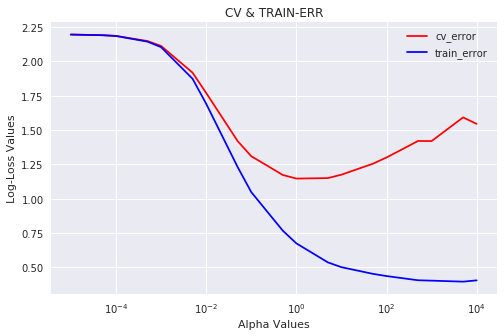

In [68]:
stacking_classifier('Training', 'OneHotEncode', vectorizer = 'TFIDF', ngram = 'Unigram')

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.701680690595617
Log-Loss for Test-set is : 1.0320028526689367
Train Accuracy is : 0.7856130403968816
Test Accuracy is : 0.6432865731462926
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


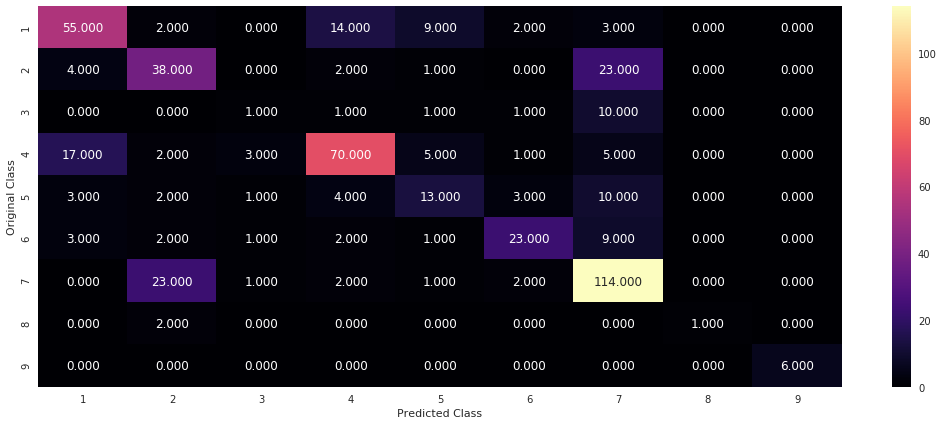

---------------------------------------- PRECISION-MATRIX ----------------------------------------


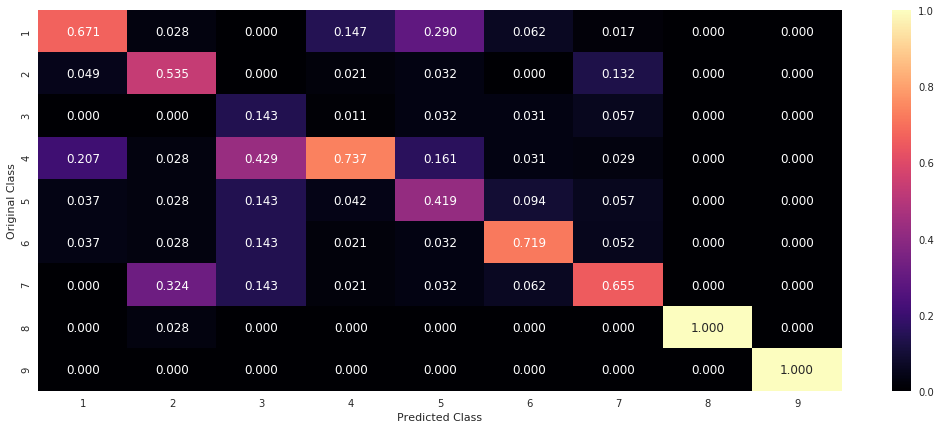

---------------------------------------- RECALL-MATRIX ----------------------------------------


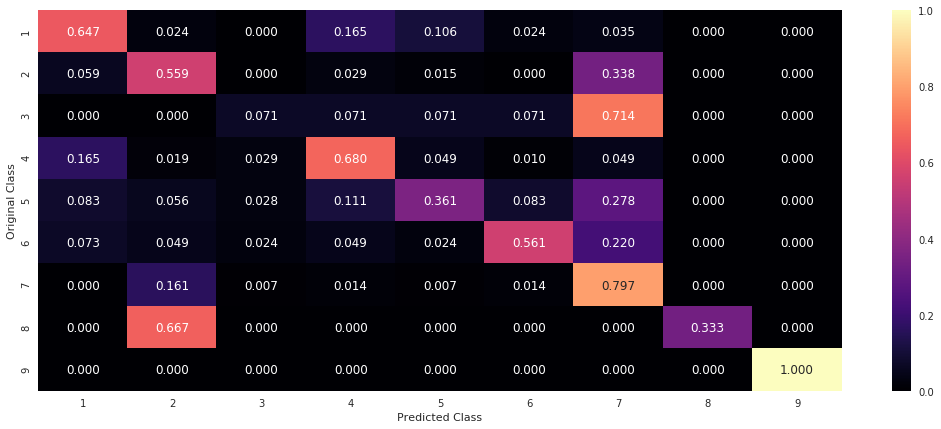

In [55]:
stacking_classifier('Testing', 'OneHotEncode', best_alpha = 1, vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* The stacking classifier did a pretty good job in classifying the data as the log loss it got is 0.70 for training data and 1.03 for test data.
* Coming to precision and recall matrix, they also look good except for the class 3.

### 8.7 Maximum Voting Classifier 

In [73]:
from sklearn.ensemble import VotingClassifier

def max_vote_classifier(encode_type, best_alpha = None, vectorizer = None, ngram = None):

    if encode_type == 'OneHotEncode':
        trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type, vectorizer, ngram)
    else:
        trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
            
    clf1 = SGDClassifier(alpha = 0.001, penalty = 'l2', loss = 'log', class_weight = 'balanced', n_jobs = -1)
    clf1.fit(trn_data, train_y)
    sig_clf1 = CalibratedClassifierCV(clf1, method = "sigmoid")
    
    clf2 = SGDClassifier(alpha = 10, penalty='l2', loss='hinge', class_weight='balanced', n_jobs = -1)
    clf2.fit(trn_data, train_y)
    sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


    clf3 = MultinomialNB(alpha = 100, fit_prior = False)
    clf3.fit(trn_data, train_y)
    sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")
    
    #clf4 = RandomForestClassifier(n_estimators = 1000, max_depth = 7)
    #clf4.fit(trn_data, train_y)
    #sig_clf4 = CalibratedClassifierCV(clf3, method="sigmoid")
    
    vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('nb', sig_clf3)], voting = 'soft')
    vclf.fit(trn_data, train_y)
        
    print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(trn_data)))
    print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(tst_data)))
    
    trn_err = vclf.score(trn_data, train_y)
    tst_err = vclf.score(tst_data, test_y)
    print('Train Accuracy is :', trn_err)
    print('Test Accuracy is :', tst_err)
    
    err_metrics(test_y, vclf.predict(tst_data))    

### [A] Precision-Recall Matrix

Log loss (train) on the VotingClassifier : 1.0028044936082794
Log loss (test) on the VotingClassifier : 1.1680774626655825
Train Accuracy is : 0.684975194897236
Test Accuracy is : 0.6412825651302605
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


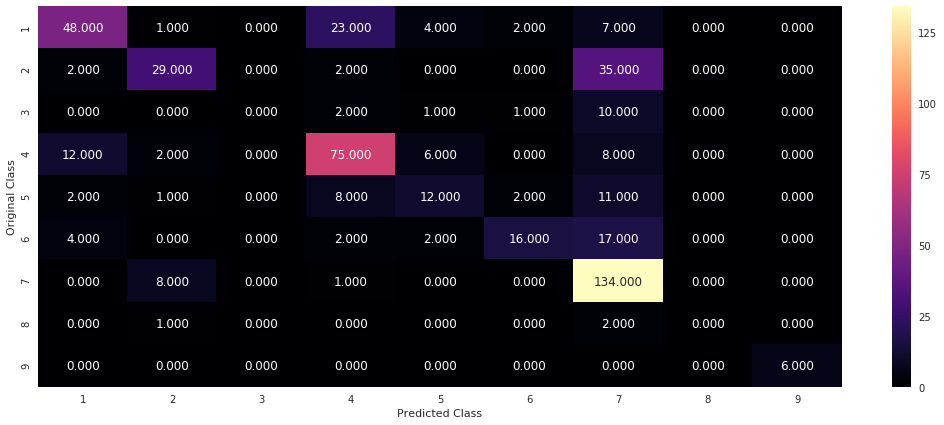

---------------------------------------- PRECISION-MATRIX ----------------------------------------


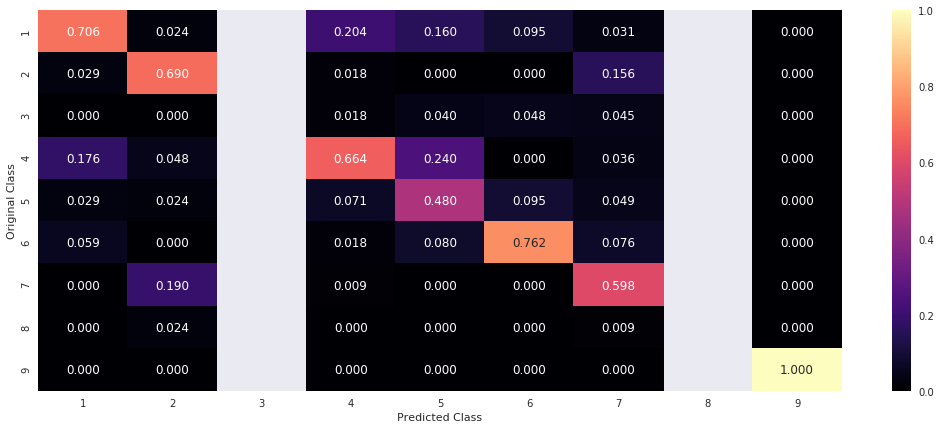

---------------------------------------- RECALL-MATRIX ----------------------------------------


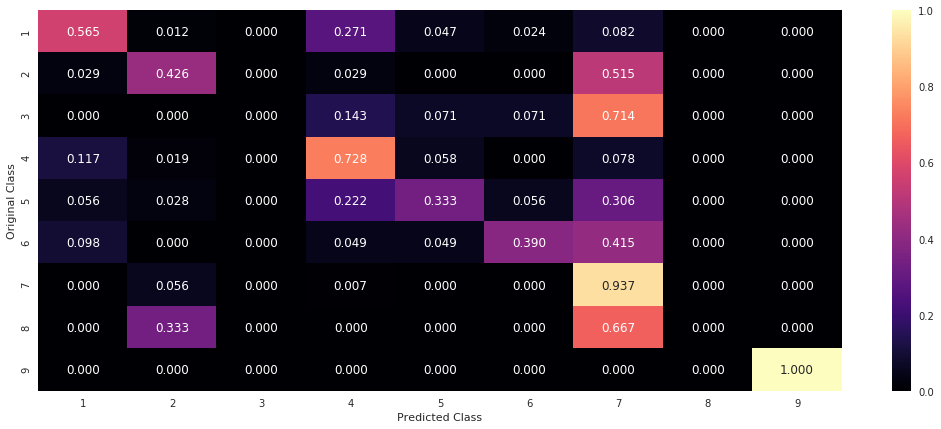

In [77]:
max_vote_classifier('OneHotEncode', vectorizer = 'TFIDF', ngram = 'Unigram')

#### Observation:
* The maximum voting classifier also did a pretty much good job but the recall matrix does not look great as the class 7 dominates in recall matrix.

### 8.8 XGBOOST 

In [84]:
import xgboost as xgb
from tqdm import tqdm
def xgboost_model(operation, encode_type, best_depth = None, best_n = None, vectorizer = None, ngram = None):
    n_base = np.array([5, 6, 7])
    depth = np.arange(2, 21, 3)
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type, vectorizer, ngram)
        else:
            trn_data, cv_data = feature_stack(train_datax, train_datay, crossv_x, crossv_y, encode_type)
        for b in tqdm(n_base):
            for d in depth:
                clf = xgb.XGBClassifier(n_estimators = b, max_depth = d, n_jobs = -1)
                clf.fit(trn_data, train_datay)
                sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
                sig_clf.fit(trn_data, train_datay)
                pred_proba_trn = sig_clf.predict_proba(trn_data)
                pred_proba_cv = sig_clf.predict_proba(cv_data)
                train_err.append(log_loss(train_datay, pred_proba_trn))
                cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_output(train_err, cv_err, depth, n_base)
    else:
        clf = xgb.XGBClassifier(n_estimators = best_n, max_depth = best_depth, n_jobs = -1)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(trn_data, train_y)
        pred_proba_trn = sig_clf.predict_proba(trn_data)
        pred_proba_tst = sig_clf.predict_proba(tst_data)
        trn_err = clf.score(trn_data, train_y)
        tst_err = clf.score(tst_data, test_y)
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

### [A] Log Loss

In [82]:
xgboost_model('Training', 'OneHotEncode', vectorizer = 'TFIDF', ngram = 'Unigram')

100%|██████████| 3/3 [05:36<00:00, 109.96s/it]

Train Error :
Log Loss for depth 2 and no. of base 5 is 1.1727200438378396
Log Loss for depth 5 and no. of base 5 is 0.8137750837368058
Log Loss for depth 8 and no. of base 5 is 0.6841039404468641
Log Loss for depth 11 and no. of base 5 is 0.6603867409049177
Log Loss for depth 14 and no. of base 5 is 0.6556955101955287
Log Loss for depth 17 and no. of base 5 is 0.6514227198056405
Log Loss for depth 20 and no. of base 5 is 0.6516252722476756
Log Loss for depth 2 and no. of base 6 is 1.1506525164993056
Log Loss for depth 5 and no. of base 6 is 0.7899654234867926
Log Loss for depth 8 and no. of base 6 is 0.6687910377286949
Log Loss for depth 11 and no. of base 6 is 0.6456928973072282
Log Loss for depth 14 and no. of base 6 is 0.6405240182579701
Log Loss for depth 17 and no. of base 6 is 0.6380335173768567
Log Loss for depth 20 and no. of base 6 is 0.6377627864059222
Log Loss for depth 2 and no. of base 7 is 1.1353439880089053
Log Loss for depth 5 and no. of base 7 is 0.7677097494382371
Lo

### [B] Precision-Recall Matrix

Log-Loss for Train-set is : 0.5420764297204459
Log-Loss for Test-set is : 1.047392612513827
Train Accuracy is : 0.9057406094968108
Test Accuracy is : 0.6733466933867736
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


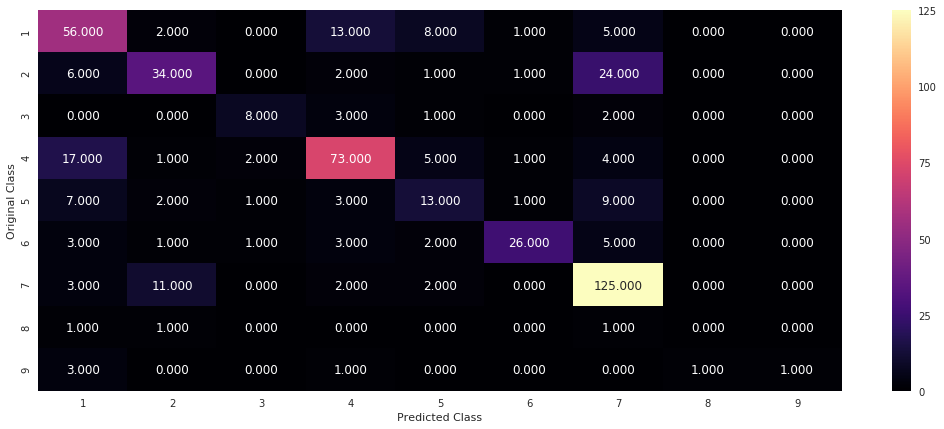

---------------------------------------- PRECISION-MATRIX ----------------------------------------


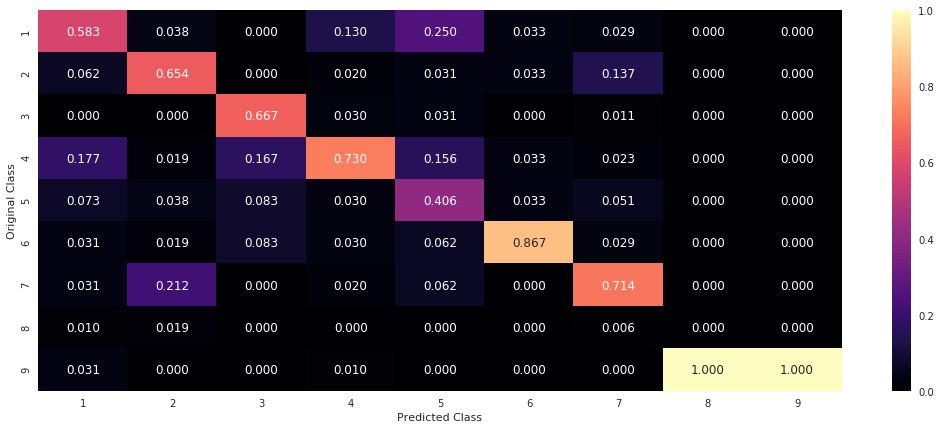

---------------------------------------- RECALL-MATRIX ----------------------------------------


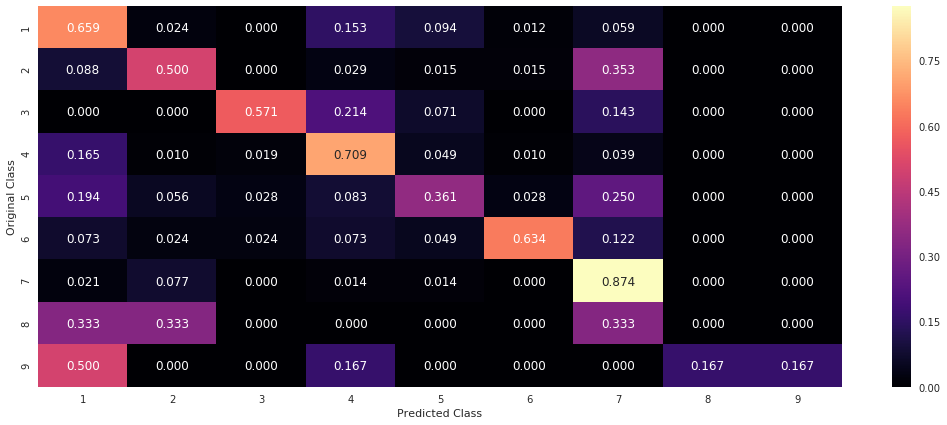

In [90]:
xgboost_model('Testing', 'OneHotEncode', vectorizer = 'TFIDF', ngram = 'Unigram', best_n = 1000, best_depth = 8)

#### Observation:
* The xgboost model has done pretty much good job as the log loss for train set is 0.54 and 1.04 for test set.
* Except for the minority class, both precision and recall matrix seems great.